In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')


C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# uncomment to disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[]


In [3]:
def compare_to_ref(ref_traj, trajs, weights, *args, method = None, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
#     weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.02)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[p,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
#             if i * ncol + j in restrained_patches and method != 'unbiased':
#                 for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
#                     pf(ax[i,j],0, color='C3')
#                 ax[i,j].spines['bottom'].set_color('y')
#                 ax[i,j].spines['top'].set_color('y') 
#                 ax[i,j].spines['right'].set_color('y')
#                 ax[i,j].spines['left'].set_color('y')
#                 ax[i,j].spines['left'].set_linewidth(2)
#                 ax[i,j].spines['top'].set_linewidth(2)
#                 ax[i,j].spines['right'].set_linewidth(2)
#                 ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
    plt.tight_layout()


## Reference Model

In [4]:
# Loading trajectory
results=pd.read_csv('Resultscounty.txt',header=None,sep='\t')
results.columns=['ID','time','county','S','E','A','I','R','P','D']
# results=pd.merge(results,parameters,on='ID')
results.sort_values(['ID','time'],ascending=True,inplace=True)
dictionary=pd.read_csv('countydictionary.csv')
dictionary.columns=['COUNTY CODE','COUNTY NAME','county']
results=pd.merge(results,dictionary,on='county')
# results=resultspatch[['time','COUNTY NAME','S','E','A','I','R','P','D','beta','tauexposed','taupresymp','tauI','casefatalityrate','COUNTY CODE']]  
results=results[['ID','time','COUNTY NAME','S','E','A','I','R','P','D']]
results.loc[:,"S":"D"] = results.loc[:,"S":"D"].div(results.loc[:,"S":"D"].sum(axis =1), axis=0)
population =pd.read_csv('popCounty.txt',index_col=False,names=['ID','Population'],header=None,sep=' ')['Population'].tolist()
population_fraction = population/np.sum(population)
area =pd.read_csv('areaCounty.txt',index_col=False,names=['ID','Area'],header=None,sep=' ')['Area'].tolist()
# Getting number of patches
patches = np.unique(results['COUNTY NAME'].values)
M = len(patches)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


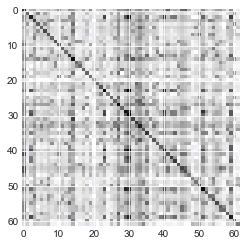

In [5]:
# load mobility matrix
networkCounty=pd.read_csv('networkCounty.txt',header=None,sep=' ')
networkCounty.columns=['ID','County','mobility_parameter']
# mobility_matrix = networkCounty.reset_index().groupby(['County'])['mobility_parameter'].apply(np.array).to_numpy()
# networkCounty = networkCounty[['ID','mobility_parameter']]
mobility_matrix = np.empty([0,M])
mobility_parameter_row = np.zeros(M)
for i,row in networkCounty.iterrows():
    mobility_parameter_row[networkCounty.loc[i, 'County']] = networkCounty.loc[i, 'mobility_parameter']
    if i < networkCounty.shape[0]-1:
        if networkCounty.loc[i+1, 'County'] == 0:
            mobility_matrix = np.append(mobility_matrix, [mobility_parameter_row], axis=0)
    #         print(mobility_parameter_row)
            mobility_parameter_row = np.zeros(M)
    else:
         mobility_matrix = np.append(mobility_matrix, [mobility_parameter_row], axis=0)

assert (np.shape(mobility_matrix)==(M,M))
mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
print (np.sum(mobility_matrix_norm, axis =1))
plt.imshow(np.log(mobility_matrix))

In [6]:
# Getting the time length
time_S = np.unique(results['time'].values)
Time_S = len(time_S)
# Getting number of trajectories
IDs = np.unique(results['ID'].values)
N = len(IDs)
np.set_printoptions(threshold=np.inf)
# Number of compartments
C = 7
ref_traj = np.empty((N, Time_S, M, C))
# start_time = 30
# end_time = 75
for n in IDs:
    for m, patch_name in enumerate(patches):
        ID = results.loc[results['ID'].isin([str(n)])]
        county = ID.loc[ID['COUNTY NAME'] == patch_name]
        traj_county = county[['S','E','A','I','R','P','D']].to_numpy()
        ref_traj[n,:,m,:] = traj_county
           
start_time = 0
end_time = 201  

Time = end_time - start_time
p = 0
# ref_traj = ref_traj[:, start_time:end_time,:,:]
## Combining P and D compartments into R
ref_traj[p,:,:,4] +=  ref_traj[p,:,:,5] + ref_traj[p,:,:,6]
ref_traj = ref_traj[p,:,:,:5]
# REF=ref_traj

# ref_traj = ref_traj[:,:,:]
ref_traj = ref_traj[np.newaxis,:,:,:]


In [7]:
# patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])
# plt.suptitle("Reference data", size=25, y=1.001)
# plt.tight_layout()
# plt.savefig('patch_quantile.png',dpi=400)
# population[0:10]
# beta = np.array([0.028905,0.052113])
# beta.shape[0]

In [8]:
## make a maxentep traj to compare 
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
eta = 1/2.492673
# alpha = 1/4
mu = 1/4.897089
epsilon = 0.586028
tmat.add_transition('E', 'A', 1/eta/(1-epsilon), 0)
tmat.add_transition('E', 'I', 1/eta/epsilon, 0)
tmat.add_transition('A', 'R', 1/mu, 0)
tmat.add_transition('I', 'R', 1/mu, 0)

infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
timesteps = 202
model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))

# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# assume starting from Bronx county
exposed_Bronx = 1/population[2]
start[2,0] = exposed_Bronx
# start[0,0] = 0.05
beta = np.array([0.028905,0.052113])
m_ref_traj = model(mobility_matrix_norm, tmat.value, start, beta)[0]
m_ref_traj = m_ref_traj[np.newaxis,:,:,:]

m_ref_traj.shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([1, 202, 62, 5])

Plotting 62 patches in a 7 x 9 grid


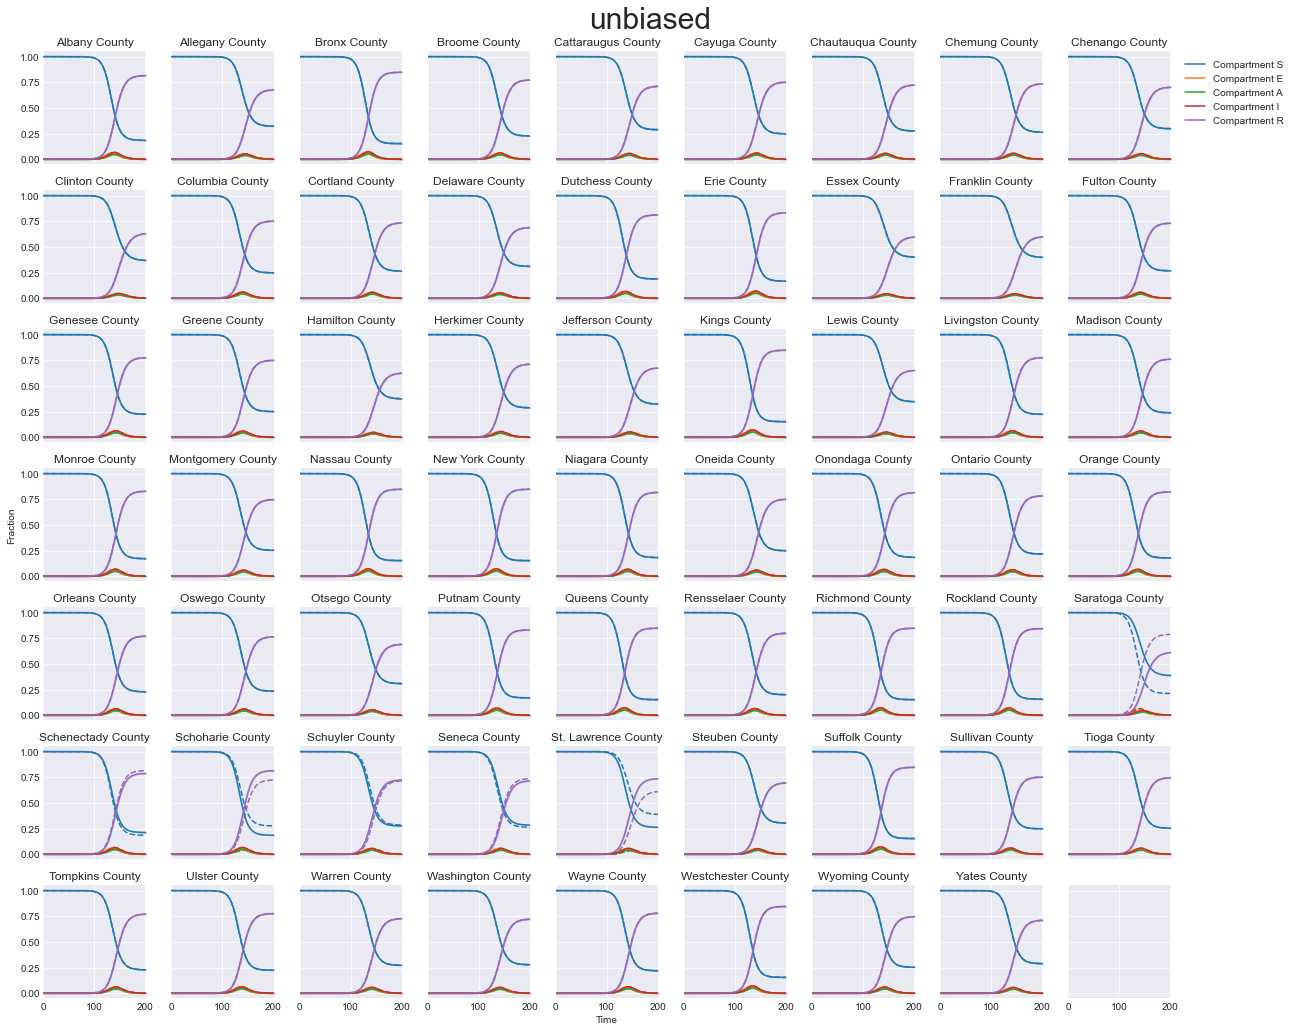

In [9]:
compare_to_ref(ref_traj, m_ref_traj, weights=None, method='unbiased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)

In [10]:
# patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])
# plt.suptitle("Reference data", size=25, y=1.001)
# plt.tight_layout()
# plt.savefig('patch_quantile.png',dpi=400)

In [11]:
# ## make a maxentep traj to compare 
# # compartment parameters
# compartments = ['E', 'A', 'I', 'R']
# full_compartments = ['S'] + compartments
# infections_compartments = [1,2]
# C = len(compartments)
# tmat = maxentep.TransitionMatrix(compartments, [1,2])
# eta = 1/2.6
# alpha = 1/2.6
# mu = 1/3.2
# tmat.add_transition('E', 'A', 1/eta, 0)
# tmat.add_transition('A', 'I', 1/alpha, 0)
# tmat.add_transition('I', 'R', 1/mu, 0)

# infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
# timesteps = 202
# model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))

# # starting fractions probabilities
# start = np.zeros((M,C)) #anywhere
# # assume starting from Bronx county
# exposed_Bronx = 1/population[2]
# start[2,0] = exposed_Bronx
# # start[0,0] = 0.05
# beta = 0.04
# m_ref_traj = model(mobility_matrix_norm, tmat.value, start, beta)[0]
# ref_traj = m_ref_traj[np.newaxis,::,:]

# patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])

In [12]:
# patch_quantile(m_ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.5, names=['S','E','A','I','R'])
# ref_traj = m_ref_traj
# total_pop = np.sum(population)
# R0 = 5
# t_max = np.log(total_pop)/mu/(R0-1)
# t_max

In [13]:
# Run this for creating frames for animations
import plotly.graph_objs as go
import plotly.figure_factory as ff 
process_traj = False
if process_traj == True:
    for t in range(T):
        infected_portion = [tf.round(ref_traj[0,t,i,3],2) for i in range(M)]
        zipcodes = dictionary['COUNTY CODE']
        fig = ff.create_choropleth(fips=zipcodes, 
                                   scope=['New York'],
                                   values=infected_portion,
                                   title='NY COVID-19 Infected Population Fraction by County',
                                   county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
                                   state_outline={'width': .5}
                                   )


        fig.update_layout(legend=dict(
            title='Infected Fraction',
            yanchor="top",
            y=0.95,
            xanchor="left",
            x=0.9,

        ))
        fig.add_annotation(dict(font=dict(color='black',size=30),
                                                x=0.4,
                                                y=0.12,
                                                showarrow=False,
                                                text="Day {}".format(t),
                                                textangle=0,
                                                xanchor='left',
                                                xref="paper",
                                                yref="paper"
                                                ))

        fig.layout.template = {'layout': {'font': {'family': 'Britannic Bold', 'size': 20}}}
        fig.write_image("NY_map//traj_" + str(t) +
                            ".png",width = 2048, height =1060)

# Run this for saving plots
if process_traj == True:
    for i in range(M):
        traj_quantile(ref_traj[:,:,i,:], names=['S','E','A','I','R','P','D'], add_legend=False, add_title = patches[i], plot_means=True)
        fig = plt.gcf()
        fig.set_size_inches(4, 4)
        #plt.savefig('{}.png'.format(patches[i]),dpi=400)
        plt.close()

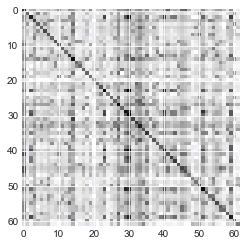

In [14]:
plt.imshow(np.log(mobility_matrix))

## Make restraints from reference trajectory

I R
Restraints are set in this time range: [75, 140]
80 0.0003527207411480819 0.0
108 0.010230259180242854 0.006144627417768667
122 0.04087582048545686 0.048851926651837366
115 0.021742622689900053 0.010785522910002355
136 0.06987339553493797 0.06749944214917981
73 0.0003975008586211702 0.009939696720751522
94 0.005236653745587705 0.0015377419427879376
129 0.25836868004580454 0.26432833203760026
108 0.028432313341279193 0.009701609382613236
80 0.0009399021886007993 0.01922218698189184
122 0.018944690378214637 0.02578892694540867
115 0.008994265965035612 0.027156750960331138
108 0.0039819999910753 0.015801964543534885
94 0.0007176798836911927 0.0
136 0.05201089728253329 0.05222746280097715
101 0.004489283351403324 0.016305607428058918
73 0.00012992325820682443 0.0
115 0.02486534075490677 0.027676927540031454
108 0.010658993890082777 0.00412030459724737
87 0.0007753425022159582 0.0
101 0.0017400922596899967 0.0
122 0.019048231095786124 0.035327465768214744
129 0.034853028572169605 0.0245

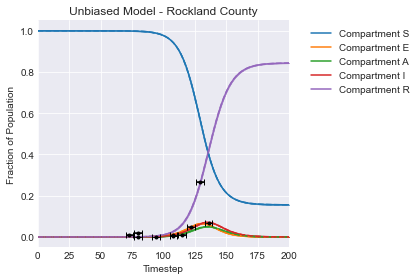

I R
[43  5 32]
43


In [15]:
compartments = ['E','A','I','R']
infections_compartments = [1,2]
full_compartments = ['S'] + compartments
npoints = 5
prior = maxentep.EmptyPrior()
# prior = maxentep.Laplace(0.1)
# p = 0

# restrained_patches = np.random.randint(M, size=number_of_restraint_patches)
number_of_restrained_patches = 3 
restrained_compartments = [3,4] #(infected patch and recovered)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
print (restrained_compartments_names)
number_of_restrained_compartments = len(restrained_compartments) 

restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)

restrained_patch = restrained_patches[0]
# def compartment_restrainer(number_of_restrained_patches,number_of_restrained_compartments,npoints,ref_traj,prior,noise=0,time_average=7):
#     if number_of_restrained_patches > M:
#         raise ValueError(
#             "Oops! Number of patches to be restrained exceeeds the total number of patches.")
# #     p = 0  # picking one trajectory from the parameter set (pick the first 1)
#     # example if number_of_restraint_patches = 2 : (recovered and infected patch)
#     restraints =[] 
#     plot_fxns_list = []
#     for i in range(number_of_restrained_patches):
#         plot_fxns = []
#         for j in range(number_of_restrained_compartments):
#             res, plfxn = maxentep.traj_to_restraints(ref_traj[p,:80,:,:], [restrained_patches[i],restrained_compartments[j]], npoints, prior, noise,time_average)
#             restraints += res 
#             plot_fxns += plfxn
#         plot_fxns_list.append(plot_fxns)
#     return restraints, plot_fxns_list


restraints, plot_fxns_list = maxentep.compartment_restrainer(restrained_patches,
                                                    restrained_compartments,ref_traj, prior,npoints=npoints,
                                                    noise=0.01,start_time=75, end_time=140)
maxentep.traj_quantile(ref_traj[:,:,restrained_patch,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[p,:,restrained_patch,:], linestyle='--')
plt.title('Unbiased Model - {}'.format(patches[restrained_patch]))
for i,pf in enumerate(plot_fxns_list[0]):
    pf(plt.gca(), 0)
plt.tight_layout()
plt.savefig('unbiased.png',dpi=200)
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.show()
print (restrained_compartments_names)
print(restrained_patches)
print(restrained_patch)

## Restraining a sample SEAIRPD to reference

In [16]:
print(max(1/np.array(population)))
print(np.mean(1/np.array(population)))
print(np.var(1/np.array(population)))

0.00021222410865874363
1.6059567615649856e-05
7.469191736144403e-10


In [17]:
# compartment parameters
compartments = ['E','A','I','R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
eta = 1/2.492673
# alpha = 1/4
mu = 1/4.897089
# epsilon = 0.6
tmat.add_transition('E', 'A', 3, 2) # call this alpha
tmat.add_transition('E', 'I', 4, 3) # call this gamma
tmat.add_transition('A', 'R',10, 5) # mu
tmat.add_transition('I', 'R', 10, 5) # mu


print(tmat.value)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_low = [0.01]*3
# hyper_pram.beta_low = 0.001
# hyper_pram.beta_high = 0.04
hyper_pram.beta_high = [0.09]*3
hyper_pram.beta_var = [0.02]*3
# hyper_pram.start_high = 2e-4
hyper_pram.start_high = 5e-3
hyper_pram.R_var = 10
hyper_pram.beta_start = 0.001
hyper_pram.start_mean = 1e-5
hyper_pram.start_scale = 1e-9

start_logits = np.zeros((M))
param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model', hypers = hyper_pram, n_infectious_compartments=2)

[[0.41666667 0.33333333 0.25       0.        ]
 [0.         0.9        0.         0.1       ]
 [0.         0.         0.9        0.1       ]
 [0.         0.         0.         1.        ]]


In [18]:
intial_exposed_guess = 1/np.array(population)
v = param_model.sample(10)
beta_dist = v[3]
# start_dist
# mask = tf.greater(start_dist, 0)
# start_exposed_dist = tf.boolean_mask(start_dist, mask).numpy()
# tf.reduce_mean(start_exposed_dist)
beta_dist

<tf.Tensor: shape=(10, 1, 2), dtype=float32, numpy=
array([[[0.03002855, 0.02552388]],

       [[0.03653324, 0.014946  ]],

       [[0.01198558, 0.03936443]],

       [[0.01087787, 0.01908273]],

       [[0.01866666, 0.02779898]],

       [[0.01279065, 0.04267614]],

       [[0.02718473, 0.02103224]],

       [[0.01546388, 0.03568943]],

       [[0.02717044, 0.03023287]],

       [[0.02987353, 0.02439296]]], dtype=float32)>

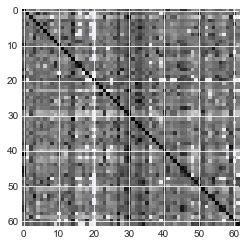

In [19]:
# Making sure our sample for mobility network is reasonable
R = v[0]
plt.imshow(np.log(R[0]))

In [20]:
intial_exposed_guess = 1/np.array(population)
import tqdm
N = 16
# N = 256
batches = 8
total_batches= N*batches
outs = []
infect = maxentep.contact_infection_func(infections_compartments, area = area)
# model = maxentep.MetaModel(infect, Time,populations = np.round(population))
model = maxentep.MetaModel(infect, Time, populations = population)
prior_prams = []
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
#     R_dist= ps[0]
#     output_list = []
#     for i in range(R_dist.shape[0]):
#         R_dist_d = mobility_matrix
#         norm_R_dist_d = R_dist_d/ tf.math.reduce_sum(R_dist_d, axis = 1, keepdims=True)
#         output_list.append(norm_R_dist_d)
#     outputs = tf.stack(output_list)
#     ps[0] = outputs
    start_dist = ps[2]
    new_start_dist = np.zeros_like(start_dist)
    start_dist_list = []
    for i in range(start_dist.shape[0]):
        index = tf.where(start_dist[i]>0)[0][0].numpy()
        new_start_dist[i,index,0] = intial_exposed_guess[index]
    start_dist_list.append(new_start_dist)
    outputs = tf.stack(start_dist_list, axis =0)
    ps[2] = tf.squeeze(outputs)
    prior_prams.append(ps)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
# trajs = trajs[:,start_time:end_time,:,:]
print(trajs.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.19s/it]

(128, 201, 62, 5)


## Visualizing the unbiased traj

Plotting 62 patches in a 7 x 9 grid


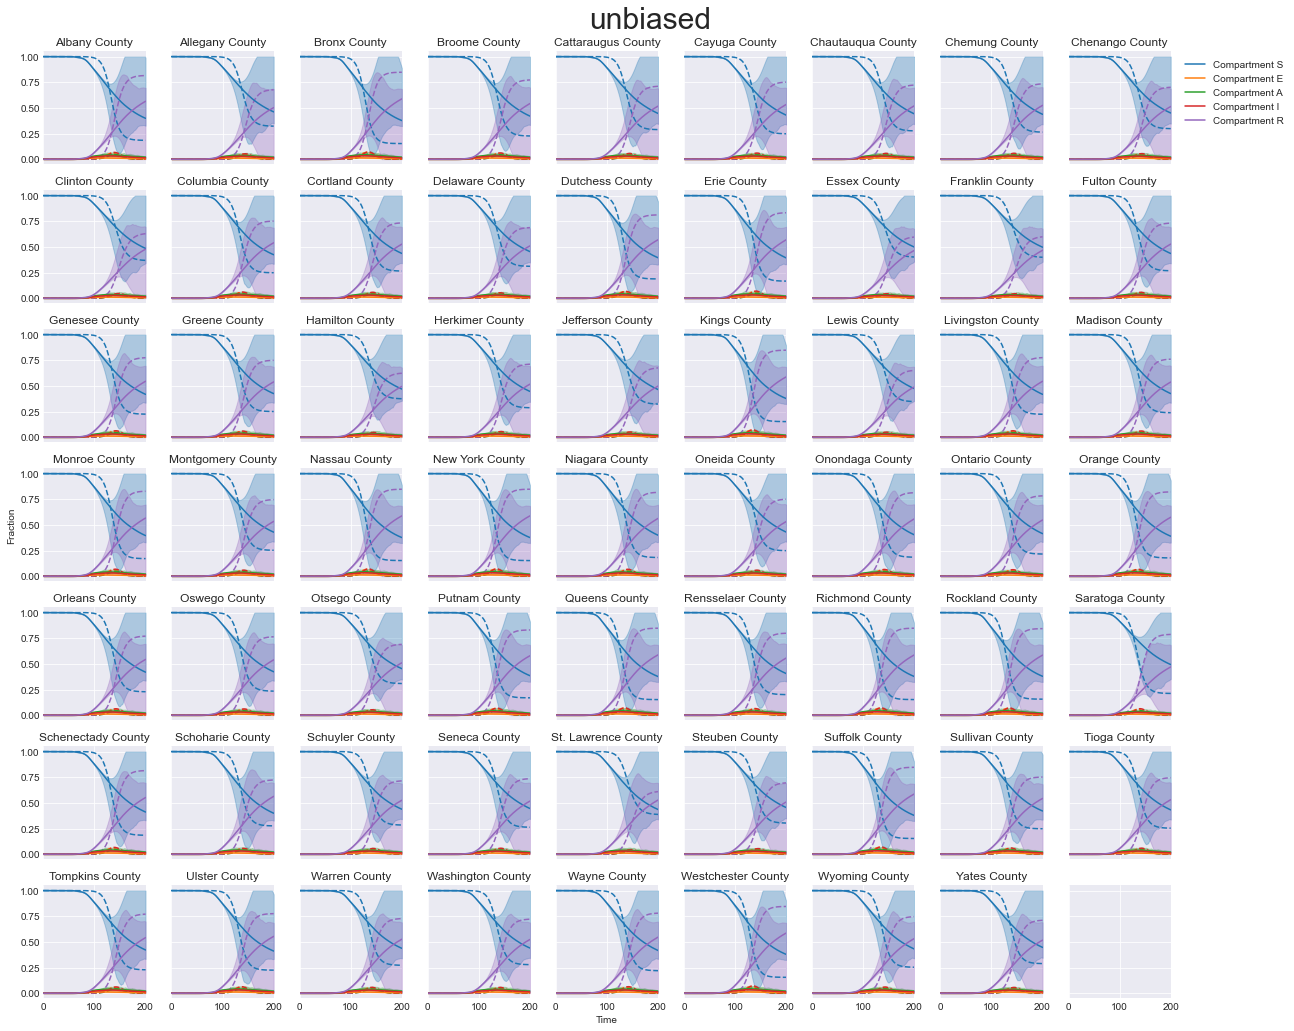

In [21]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
compare_to_ref(ref_traj,trajs, weights=None, method='unbiased', patch_names = patches, 
               figsize=(18, 14), alpha=0.3, names=full_compartments)

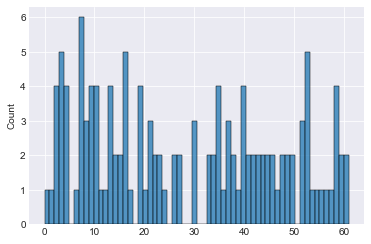

In [22]:
prior_exposed_patch = maxentep.exposed_finder(trajs)
sns.histplot(x=prior_exposed_patch, label='Prior', color='C0',bins=M)

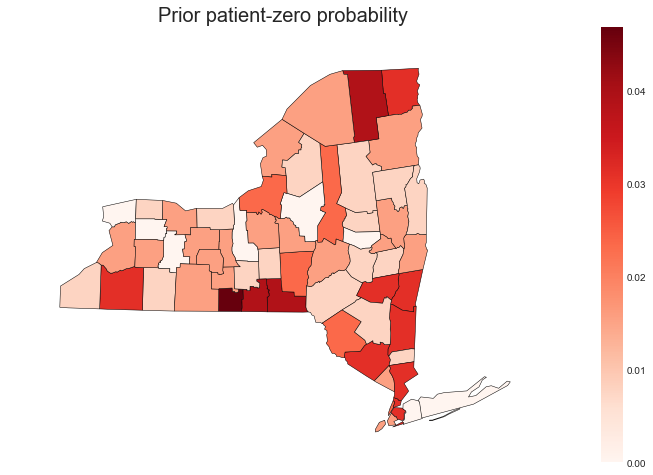

In [23]:
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability',
                fontsize=20, choropleth=True,
       geojson='counties_ny.geojson')

In [24]:
def get_dist(prior_prams):
    R_dist = []
    T_dist = []
    start_dist = []
    beta_dist = []
    for i in range(len(prior_prams)):
        param_batch = prior_prams[i]
#         R_dist.append(param_batch[0])
        T_dist.append(param_batch[1])
        start_dist.append(param_batch[2])
        beta_dist.append(param_batch[3])
#     R_dist = tf.concat(R_dist, axis = 0)
    T_dist = tf.concat(T_dist, axis = 0)
    start_dist = tf.concat(start_dist, axis = 0)
    beta_dist = tf.concat(beta_dist, axis = 0)
    # get eta^-1
    E_A = 1/T_dist[:, compartments.index('E'), compartments.index('A')].numpy()
    # get gamma^-1
    E_I = 1/T_dist[:, compartments.index('E'), compartments.index('I')].numpy()
    # get mu^-1
    A_R = 1/T_dist[:, compartments.index('A'), compartments.index('R')].numpy()
    # get mu^-1
    I_R = 1/T_dist[:, compartments.index('I'), compartments.index('R')].numpy()
    # Getting starting exposed fraction 
    mask = tf.greater(start_dist, 0)
    start_exposed_dist = tf.boolean_mask(start_dist, mask).numpy()
    return [E_A, E_I,A_R, I_R, start_exposed_dist, beta_dist]
    
def plot_dist(E_A, E_I, A_R, I_R, start_exposed_dist, beta_dist, name='Prior'):
    import seaborn as sns
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,6), dpi=200)
    fig.suptitle(f'{name} distributions', fontsize=20,y=1.00)
    sns.distplot(x=beta_dist[...,0], ax = axs[0,0], axlabel=r'$\beta_{A}$')
    sns.distplot(x=beta_dist[...,1], ax = axs[0,1], axlabel=r'$\beta_{I}$')
    sns.distplot(x=E_A, ax = axs[0,2], axlabel=r'$\alpha^{-1}$ : E->A (days)')
    sns.distplot(x=E_I, ax = axs[1,0], axlabel=r'$\gamma^{-1}$ : E->I (days)')
    sns.distplot(x=A_R, ax = axs[1,1], axlabel=r'$\mu_{A}^{-1}$ : A->R (days)')
    sns.distplot(x=I_R, ax = axs[1,2], axlabel=r'$\mu_{I}^{-1}$ : I->R (days)')
#     sns.distplot(x=E_A, ax = axs[1,0], axlabel=r'$\eta^{-1}$ : E->A (days)')
#     sns.distplot(x=A_I, ax = axs[1,1], axlabel=r'$\alpha ^{-1}$ : A->I (days)')
#     sns.distplot(x=I_R, ax = axs[1,1], axlabel=r'$\mu^{-1}$ : I->R (days)')

In [25]:
prior_param_dist = get_dist(prior_prams)

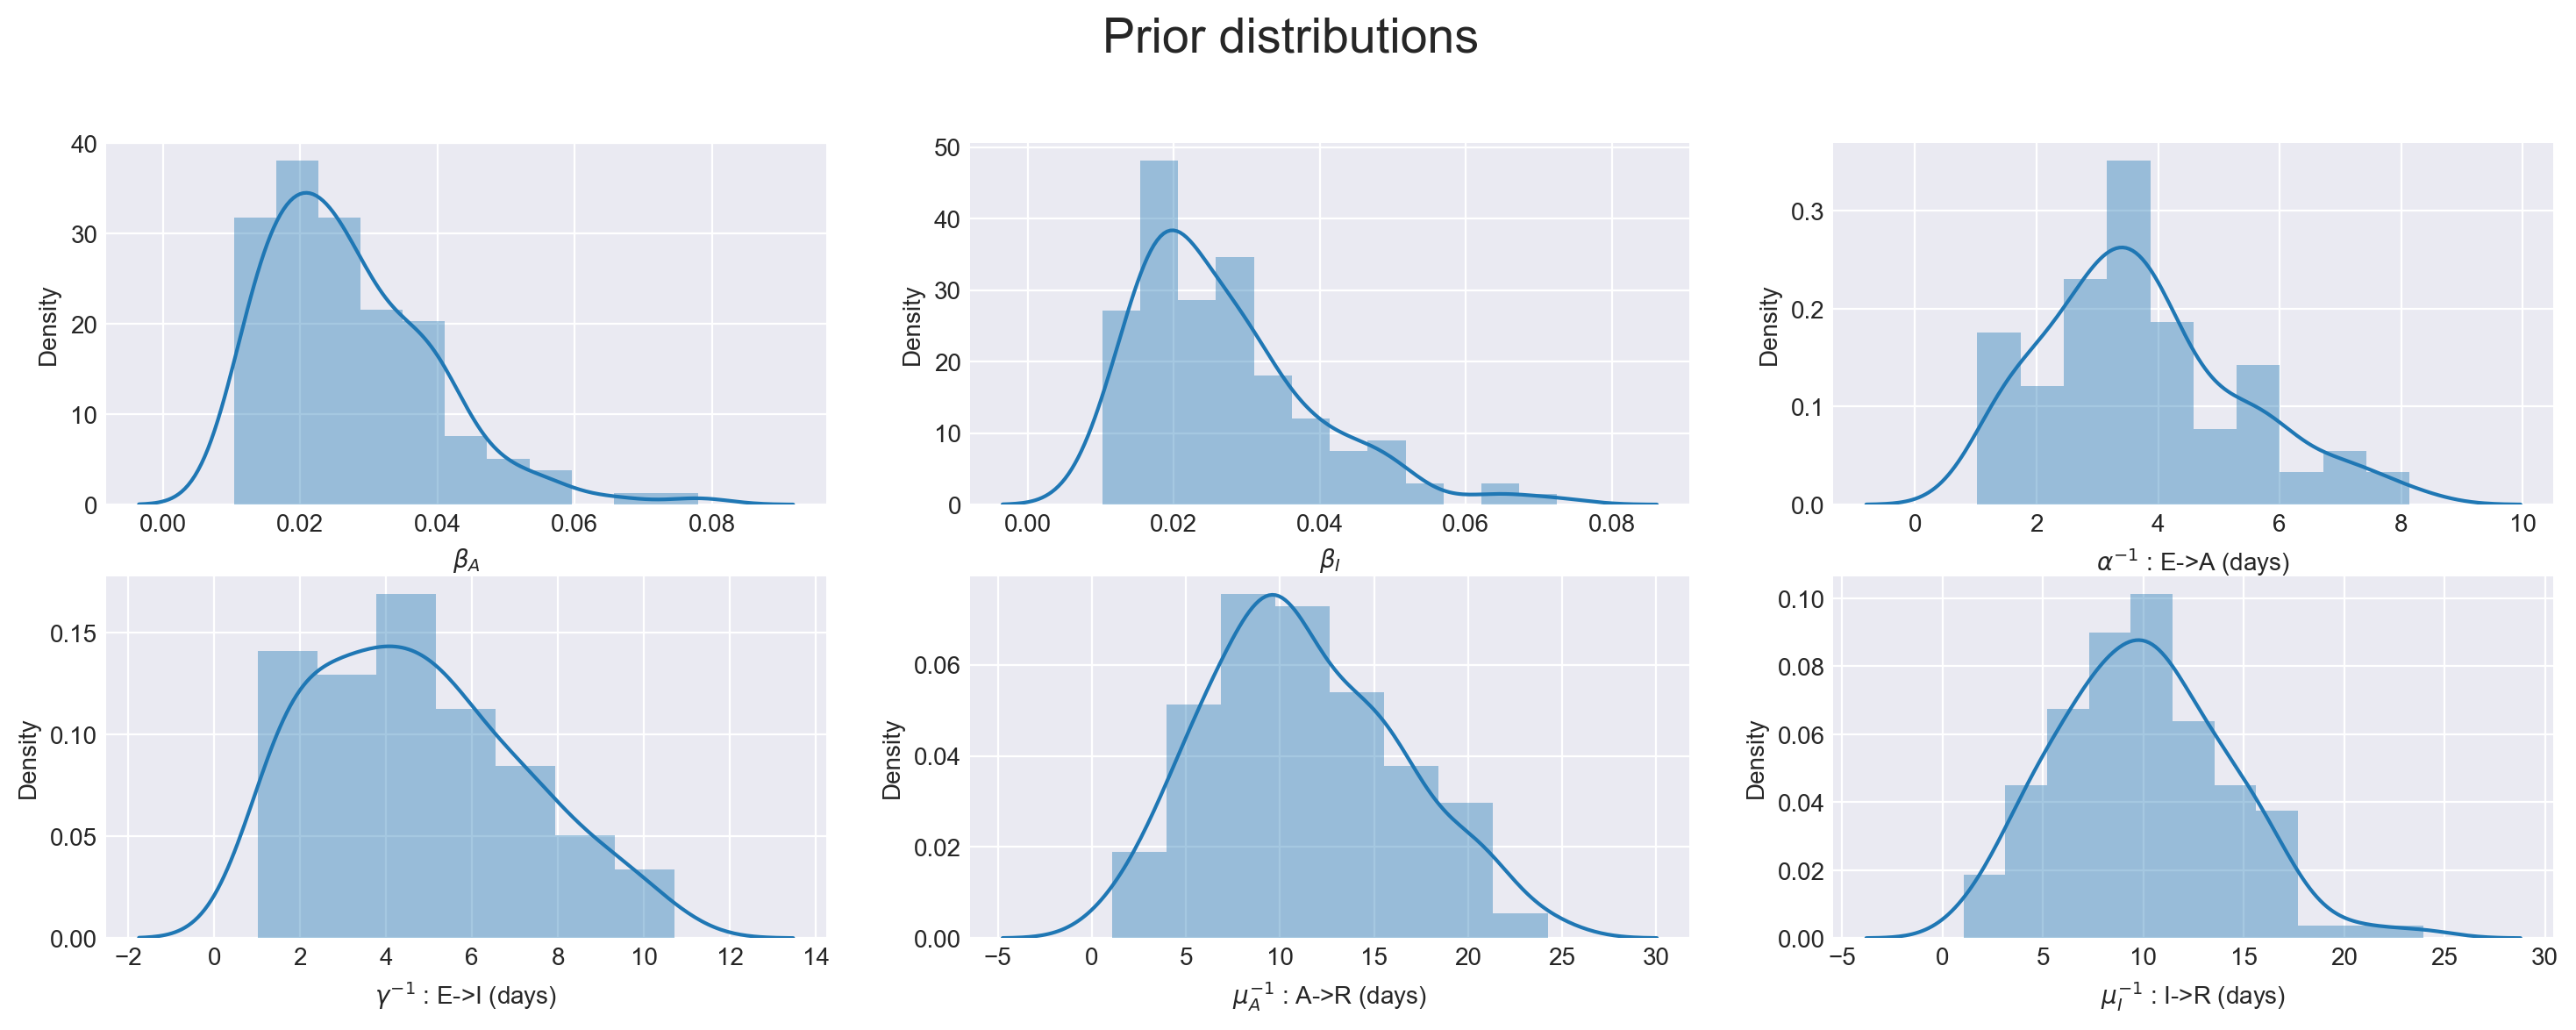

In [26]:
plot_dist(*prior_param_dist)

In [27]:
# ref_traj = tf.squeeze(ref_traj)
# if tf.rank(ref_traj).numpy() != 4:
#     ref_traj = ref_traj[tf.newaxis, ...]
# ref_traj.shape

In [28]:

# print (restrained_compartments_names)
# npoints =4
# prior = maxentep.EmptyPrior()
# cutting the ref_traj in half
# restraints_R, plot_fxn_R = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [restrained_patch,4], npoints, prior, noise=0,time_average=7)
#restraints_E, plot_fxn_E = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,1], npoints, prior, noise=0,time_average=7)
#restraints_A, plot_fxn_A = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,2], npoints, prior, noise=0,time_average=7)
# restraints_I, plot_fxn_I = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [restrained_patch,3], npoints, prior, noise=0,time_average=7)
#restraints_P, plot_fxn_P = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,5], npoints, prior, noise=0,time_average=7)
#restraints_D, plot_fxn_D = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,6], npoints, prior, noise=0,time_average=7)
#restraints = restraints_R + restraints_E + restraints_A + restraints_I + restraints_P + restraints_D
#plot_fxns = plot_fxn_R + plot_fxn_E + plot_fxn_A + plot_fxn_I + plot_fxn_P + plot_fxn_D
# restraints = restraints_I + restraints_R
# plot_fxns = plot_fxn_I + plot_fxn_R


In [29]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')

In [30]:
# class CustomCallback(tf.keras.callbacks.Callback):
#     def __init__(self):
#         self. i = 0
#     def on_epoch_begin(self, epoch, logs=None):
#         self.i += 1
#         return self.i


In [31]:
me_history = me_model.fit(trajs, batch_size=N//2,epochs=1000)#, callbacks=[CustomCallback()])

Epoch 1/1000
16/16 [==============================] - 0s 623us/step - loss: 0.0028 - weight-entropy: 1.9857
Epoch 2/1000
16/16 [==============================] - 0s 685us/step - loss: 0.0015 - weight-entropy: 1.8733
Epoch 3/1000
16/16 [==============================] - 0s 623us/step - loss: 0.0014 - weight-entropy: 1.8875
Epoch 4/1000
16/16 [==============================] - 0s 873us/step - loss: 0.0014 - weight-entropy: 1.8723
Epoch 5/1000
16/16 [==============================] - 0s 980us/step - loss: 0.0015 - weight-entropy: 1.8923
Epoch 6/1000
16/16 [==============================] - 0s 810us/step - loss: 0.0011 - weight-entropy: 1.8906
Epoch 7/1000
16/16 [==============================] - 0s 927us/step - loss: 0.0014 - weight-entropy: 1.8606
Epoch 8/1000
16/16 [==============================] - 0s 624us/step - loss: 0.0012 - weight-entropy: 1.8948
Epoch 9/1000
16/16 [==============================] - 0s 561us/step - loss: 0.0010 - weight-entropy: 1.9114
Epoch 10/1000
16/16 [=======

16/16 [==============================] - 0s 499us/step - loss: 0.0010 - weight-entropy: 1.8324
Epoch 76/1000
16/16 [==============================] - 0s 623us/step - loss: 8.2995e-04 - weight-entropy: 1.8087
Epoch 77/1000
16/16 [==============================] - 0s 561us/step - loss: 0.0012 - weight-entropy: 1.8691
Epoch 78/1000
16/16 [==============================] - 0s 499us/step - loss: 8.0335e-04 - weight-entropy: 1.8451
Epoch 79/1000
16/16 [==============================] - 0s 561us/step - loss: 7.8115e-04 - weight-entropy: 1.8255
Epoch 80/1000
16/16 [==============================] - 0s 500us/step - loss: 9.3537e-04 - weight-entropy: 1.8385
Epoch 81/1000
16/16 [==============================] - 0s 436us/step - loss: 7.9275e-04 - weight-entropy: 1.8626
Epoch 82/1000
16/16 [==============================] - 0s 500us/step - loss: 8.4784e-04 - weight-entropy: 1.8172
Epoch 83/1000
16/16 [==============================] - 0s 497us/step - loss: 8.4163e-04 - weight-entropy: 1.8287
Epoch

16/16 [==============================] - 0s 561us/step - loss: 9.3460e-04 - weight-entropy: 1.7025
Epoch 149/1000
16/16 [==============================] - 0s 623us/step - loss: 9.3560e-04 - weight-entropy: 1.7326
Epoch 150/1000
16/16 [==============================] - 0s 561us/step - loss: 8.2296e-04 - weight-entropy: 1.6948
Epoch 151/1000
16/16 [==============================] - 0s 810us/step - loss: 8.0358e-04 - weight-entropy: 1.6951
Epoch 152/1000
16/16 [==============================] - 0s 623us/step - loss: 0.0010 - weight-entropy: 1.7384
Epoch 153/1000
16/16 [==============================] - 0s 625us/step - loss: 9.5818e-04 - weight-entropy: 1.7752
Epoch 154/1000
16/16 [==============================] - 0s 623us/step - loss: 0.0012 - weight-entropy: 1.8068
Epoch 155/1000
16/16 [==============================] - 0s 559us/step - loss: 0.0011 - weight-entropy: 1.7970
Epoch 156/1000
16/16 [==============================] - 0s 686us/step - loss: 7.8719e-04 - weight-entropy: 1.7735
E

16/16 [==============================] - 0s 561us/step - loss: 6.6807e-04 - weight-entropy: 1.6610
Epoch 221/1000
16/16 [==============================] - 0s 561us/step - loss: 7.9667e-04 - weight-entropy: 1.6932
Epoch 222/1000
16/16 [==============================] - 0s 561us/step - loss: 0.0010 - weight-entropy: 1.7164
Epoch 223/1000
16/16 [==============================] - 0s 563us/step - loss: 8.8849e-04 - weight-entropy: 1.7321
Epoch 224/1000
16/16 [==============================] - 0s 561us/step - loss: 9.9534e-04 - weight-entropy: 1.7274
Epoch 225/1000
16/16 [==============================] - 0s 686us/step - loss: 8.9889e-04 - weight-entropy: 1.7232
Epoch 226/1000
16/16 [==============================] - 0s 561us/step - loss: 8.9718e-04 - weight-entropy: 1.6756
Epoch 227/1000
16/16 [==============================] - 0s 623us/step - loss: 8.4705e-04 - weight-entropy: 1.6285
Epoch 228/1000
16/16 [==============================] - 0s 748us/step - loss: 9.1900e-04 - weight-entropy: 

16/16 [==============================] - 0s 501us/step - loss: 0.0010 - weight-entropy: 1.6501
Epoch 293/1000
16/16 [==============================] - 0s 561us/step - loss: 8.7219e-04 - weight-entropy: 1.6344
Epoch 294/1000
16/16 [==============================] - 0s 623us/step - loss: 0.0010 - weight-entropy: 1.6302
Epoch 295/1000
16/16 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 1.6677
Epoch 296/1000
16/16 [==============================] - 0s 686us/step - loss: 6.0116e-04 - weight-entropy: 1.6575
Epoch 297/1000
16/16 [==============================] - 0s 561us/step - loss: 0.0010 - weight-entropy: 1.7172
Epoch 298/1000
16/16 [==============================] - 0s 623us/step - loss: 8.9431e-04 - weight-entropy: 1.6868
Epoch 299/1000
16/16 [==============================] - 0s 686us/step - loss: 7.9954e-04 - weight-entropy: 1.6471
Epoch 300/1000
16/16 [==============================] - 0s 748us/step - loss: 0.0010 - weight-entropy: 1.7072
Epoch 301/1

16/16 [==============================] - 0s 499us/step - loss: 8.9693e-04 - weight-entropy: 1.6818
Epoch 365/1000
16/16 [==============================] - 0s 561us/step - loss: 0.0014 - weight-entropy: 1.6147
Epoch 366/1000
16/16 [==============================] - 0s 499us/step - loss: 9.9900e-04 - weight-entropy: 1.5898
Epoch 367/1000
16/16 [==============================] - 0s 561us/step - loss: 9.1700e-04 - weight-entropy: 1.6441
Epoch 368/1000
16/16 [==============================] - 0s 499us/step - loss: 7.3465e-04 - weight-entropy: 1.5845
Epoch 369/1000
16/16 [==============================] - 0s 499us/step - loss: 6.5508e-04 - weight-entropy: 1.5899
Epoch 370/1000
16/16 [==============================] - 0s 497us/step - loss: 9.4256e-04 - weight-entropy: 1.6479
Epoch 371/1000
16/16 [==============================] - 0s 500us/step - loss: 8.7064e-04 - weight-entropy: 1.6122
Epoch 372/1000
16/16 [==============================] - 0s 436us/step - loss: 8.0778e-04 - weight-entropy: 

16/16 [==============================] - 0s 561us/step - loss: 8.7077e-04 - weight-entropy: 1.5990
Epoch 437/1000
16/16 [==============================] - 0s 499us/step - loss: 0.0011 - weight-entropy: 1.5899
Epoch 438/1000
16/16 [==============================] - 0s 500us/step - loss: 9.8633e-04 - weight-entropy: 1.5989
Epoch 439/1000
16/16 [==============================] - 0s 499us/step - loss: 8.6420e-04 - weight-entropy: 1.6472
Epoch 440/1000
16/16 [==============================] - 0s 561us/step - loss: 9.1393e-04 - weight-entropy: 1.6464
Epoch 441/1000
16/16 [==============================] - 0s 561us/step - loss: 8.7270e-04 - weight-entropy: 1.6410
Epoch 442/1000
16/16 [==============================] - 0s 562us/step - loss: 9.5609e-04 - weight-entropy: 1.6211
Epoch 443/1000
16/16 [==============================] - 0s 746us/step - loss: 8.7010e-04 - weight-entropy: 1.6248
Epoch 444/1000
16/16 [==============================] - 0s 997us/step - loss: 8.1113e-04 - weight-entropy: 

16/16 [==============================] - 0s 563us/step - loss: 9.2582e-04 - weight-entropy: 1.6626
Epoch 509/1000
16/16 [==============================] - 0s 499us/step - loss: 9.7142e-04 - weight-entropy: 1.7138
Epoch 510/1000
16/16 [==============================] - 0s 561us/step - loss: 7.0742e-04 - weight-entropy: 1.6146
Epoch 511/1000
16/16 [==============================] - 0s 561us/step - loss: 8.1218e-04 - weight-entropy: 1.6641
Epoch 512/1000
16/16 [==============================] - 0s 497us/step - loss: 7.7882e-04 - weight-entropy: 1.6470
Epoch 513/1000
16/16 [==============================] - 0s 499us/step - loss: 9.0534e-04 - weight-entropy: 1.6259
Epoch 514/1000
16/16 [==============================] - 0s 499us/step - loss: 6.9425e-04 - weight-entropy: 1.5918
Epoch 515/1000
16/16 [==============================] - 0s 500us/step - loss: 8.0549e-04 - weight-entropy: 1.5710
Epoch 516/1000
16/16 [==============================] - 0s 497us/step - loss: 9.1718e-04 - weight-entro

16/16 [==============================] - 0s 562us/step - loss: 7.5262e-04 - weight-entropy: 1.6398
Epoch 581/1000
16/16 [==============================] - 0s 686us/step - loss: 7.3753e-04 - weight-entropy: 1.5614
Epoch 582/1000
16/16 [==============================] - 0s 561us/step - loss: 7.3309e-04 - weight-entropy: 1.5699
Epoch 583/1000
16/16 [==============================] - 0s 561us/step - loss: 6.7183e-04 - weight-entropy: 1.6051
Epoch 584/1000
16/16 [==============================] - 0s 499us/step - loss: 0.0010 - weight-entropy: 1.5352
Epoch 585/1000
16/16 [==============================] - 0s 686us/step - loss: 9.3837e-04 - weight-entropy: 1.5677
Epoch 586/1000
16/16 [==============================] - 0s 686us/step - loss: 0.0010 - weight-entropy: 1.5909
Epoch 587/1000
16/16 [==============================] - 0s 939us/step - loss: 0.0013 - weight-entropy: 1.5957
Epoch 588/1000
16/16 [==============================] - 0s 735us/step - loss: 6.2433e-04 - weight-entropy: 1.5795
E

16/16 [==============================] - 0s 561us/step - loss: 0.0010 - weight-entropy: 1.5296
Epoch 653/1000
16/16 [==============================] - 0s 498us/step - loss: 9.0551e-04 - weight-entropy: 1.5337
Epoch 654/1000
16/16 [==============================] - 0s 626us/step - loss: 7.2418e-04 - weight-entropy: 1.4987
Epoch 655/1000
16/16 [==============================] - 0s 559us/step - loss: 8.8991e-04 - weight-entropy: 1.5245
Epoch 656/1000
16/16 [==============================] - 0s 561us/step - loss: 9.3776e-04 - weight-entropy: 1.5150
Epoch 657/1000
16/16 [==============================] - 0s 561us/step - loss: 7.8163e-04 - weight-entropy: 1.5481
Epoch 658/1000
16/16 [==============================] - 0s 499us/step - loss: 8.5841e-04 - weight-entropy: 1.5673
Epoch 659/1000
16/16 [==============================] - 0s 561us/step - loss: 8.3595e-04 - weight-entropy: 1.6247
Epoch 660/1000
16/16 [==============================] - 0s 562us/step - loss: 9.2451e-04 - weight-entropy: 

16/16 [==============================] - 0s 561us/step - loss: 9.4257e-04 - weight-entropy: 1.5971
Epoch 725/1000
16/16 [==============================] - 0s 500us/step - loss: 0.0011 - weight-entropy: 1.6409
Epoch 726/1000
16/16 [==============================] - 0s 623us/step - loss: 7.6781e-04 - weight-entropy: 1.5703
Epoch 727/1000
16/16 [==============================] - 0s 561us/step - loss: 8.2339e-04 - weight-entropy: 1.5974
Epoch 728/1000
16/16 [==============================] - 0s 562us/step - loss: 9.1275e-04 - weight-entropy: 1.6213
Epoch 729/1000
16/16 [==============================] - 0s 561us/step - loss: 9.5896e-04 - weight-entropy: 1.6148
Epoch 730/1000
16/16 [==============================] - 0s 499us/step - loss: 8.6810e-04 - weight-entropy: 1.5832
Epoch 731/1000
16/16 [==============================] - 0s 500us/step - loss: 0.0014 - weight-entropy: 1.6340
Epoch 732/1000
16/16 [==============================] - 0s 499us/step - loss: 7.2641e-04 - weight-entropy: 1.50

16/16 [==============================] - 0s 497us/step - loss: 9.9675e-04 - weight-entropy: 1.5385
Epoch 797/1000
16/16 [==============================] - 0s 435us/step - loss: 0.0011 - weight-entropy: 1.5548
Epoch 798/1000
16/16 [==============================] - 0s 500us/step - loss: 0.0011 - weight-entropy: 1.5062
Epoch 799/1000
16/16 [==============================] - 0s 561us/step - loss: 9.0652e-04 - weight-entropy: 1.5025
Epoch 800/1000
16/16 [==============================] - 0s 562us/step - loss: 9.1792e-04 - weight-entropy: 1.4617
Epoch 801/1000
16/16 [==============================] - 0s 499us/step - loss: 7.4316e-04 - weight-entropy: 1.5847
Epoch 802/1000
16/16 [==============================] - 0s 748us/step - loss: 7.1535e-04 - weight-entropy: 1.5398
Epoch 803/1000
16/16 [==============================] - 0s 686us/step - loss: 9.5807e-04 - weight-entropy: 1.6341
Epoch 804/1000
16/16 [==============================] - 0s 627us/step - loss: 6.7377e-04 - weight-entropy: 1.53

16/16 [==============================] - 0s 499us/step - loss: 6.4423e-04 - weight-entropy: 1.4643
Epoch 869/1000
16/16 [==============================] - 0s 499us/step - loss: 0.0011 - weight-entropy: 1.5872
Epoch 870/1000
16/16 [==============================] - 0s 561us/step - loss: 9.6127e-04 - weight-entropy: 1.5482
Epoch 871/1000
16/16 [==============================] - 0s 500us/step - loss: 0.0010 - weight-entropy: 1.5220
Epoch 872/1000
16/16 [==============================] - 0s 498us/step - loss: 7.9736e-04 - weight-entropy: 1.5303
Epoch 873/1000
16/16 [==============================] - 0s 499us/step - loss: 7.6746e-04 - weight-entropy: 1.5590
Epoch 874/1000
16/16 [==============================] - 0s 499us/step - loss: 8.2441e-04 - weight-entropy: 1.5043
Epoch 875/1000
16/16 [==============================] - 0s 499us/step - loss: 0.0010 - weight-entropy: 1.5348
Epoch 876/1000
16/16 [==============================] - 0s 499us/step - loss: 7.5727e-04 - weight-entropy: 1.4540
E

16/16 [==============================] - 0s 499us/step - loss: 9.2634e-04 - weight-entropy: 1.5659
Epoch 941/1000
16/16 [==============================] - 0s 436us/step - loss: 7.6906e-04 - weight-entropy: 1.6197
Epoch 942/1000
16/16 [==============================] - 0s 499us/step - loss: 0.0011 - weight-entropy: 1.5990
Epoch 943/1000
16/16 [==============================] - 0s 434us/step - loss: 8.0169e-04 - weight-entropy: 1.5932
Epoch 944/1000
16/16 [==============================] - 0s 436us/step - loss: 7.4187e-04 - weight-entropy: 1.5346
Epoch 945/1000
16/16 [==============================] - 0s 499us/step - loss: 0.0011 - weight-entropy: 1.5558
Epoch 946/1000
16/16 [==============================] - 0s 499us/step - loss: 8.2122e-04 - weight-entropy: 1.5919
Epoch 947/1000
16/16 [==============================] - 0s 436us/step - loss: 6.6460e-04 - weight-entropy: 1.5222
Epoch 948/1000
16/16 [==============================] - 0s 436us/step - loss: 0.0011 - weight-entropy: 1.5467
E

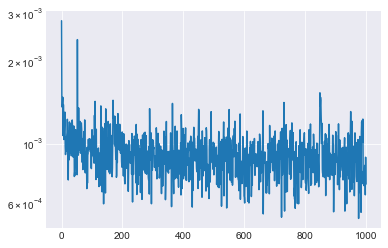

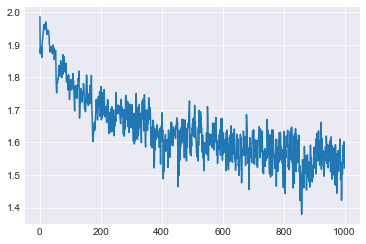

In [32]:
plt.plot(me_history.history['loss'])
plt.yscale('log')
plt.show()
plt.plot(me_history.history['weight-entropy'])
plt.show()

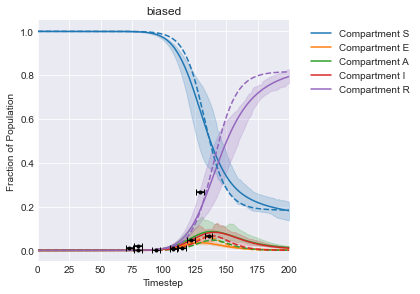

In [33]:
patch_number = 0
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights,alpha=0.2, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(plt, me_model.lambdas[i], color='k')
plt.tight_layout()
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.title('biased')
plt.show()

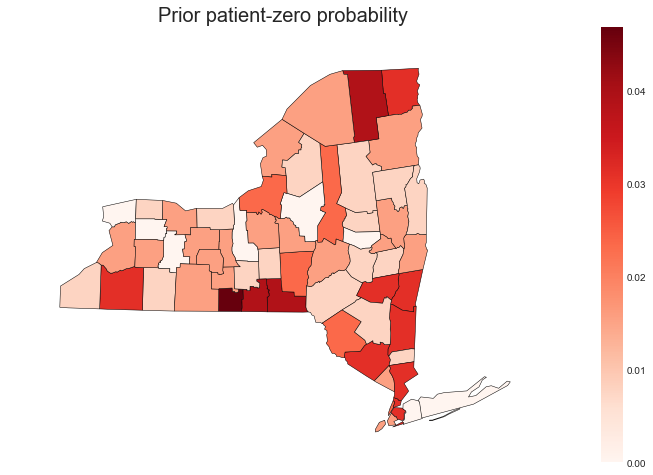

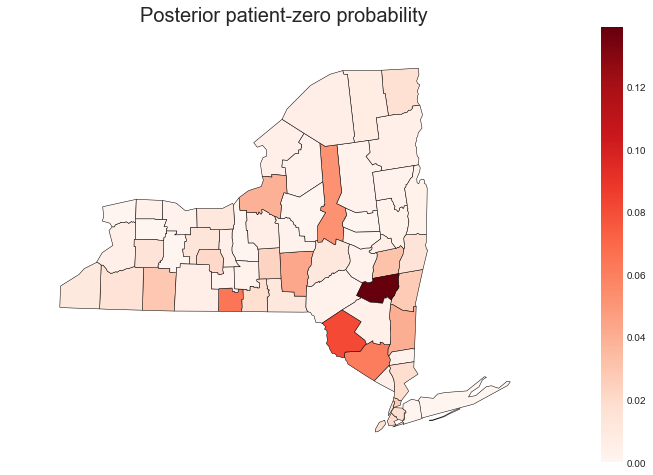

In [34]:
me_w = me_model.traj_weights
prior_exposed_patch = maxentep.exposed_finder(trajs)
posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=20, choropleth=True,
       geojson='counties_ny.geojson')
maxentep.p0_map(prior_exposed_patch, M, weights = me_w, title = 'Posterior patient-zero probability', patch_names=patches, fontsize=20
      , choropleth=True, geojson='counties_ny.geojson')

In [35]:
sorted(zip(prior_exposed_patch, patches), reverse=True)[:5]

[(61, 'Saratoga County'),
 (60, 'Dutchess County'),
 (59, 'Putnam County'),
 (54, 'Allegany County'),
 (53, 'Livingston County')]

In [36]:
sorted(zip(posterior_exposed_prob, patches), reverse=True)[:5]

[(0.1390345797236805, 'Greene County'),
 (0.08178434259730401, 'Sullivan County'),
 (0.06446321102709238, 'Chemung County'),
 (0.06104841633349949, 'Orange County'),
 (0.05257145892546929, 'Herkimer County')]

## Algorithm 2

In [37]:
fit_param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model',hypers = hyper_pram,  n_infectious_compartments=2)
fit_param_model.compile(tf.optimizers.SGD(1))

hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.SGD(learning_rate=1), 'mean_squared_error')

In [38]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=3, param_epochs=50, batch_size=N, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 998us/step - loss: 0.0604 - weight-entropy: 2.7726
Epoch 2/100
1/1 [==============================] - 0s 975us/step - loss: 0.0381 - weight-entropy: 2.7503
Epoch 3/100
1/1 [==============================] - 0s 997us/step - loss: 0.0267 - weight-entropy: 2.7120
Epoch 4/100
1/1 [==============================] - 0s 0s/step - loss: 0.0204 - weight-entropy: 2.6753
Epoch 5/100
1/1 [==============================] - 0s 996us/step - loss: 0.0164 - weight-entropy: 2.6433
Epoch 6/100
1/1 [==============================] - 0s 0s/step - loss: 0.0138 - weight-entropy: 2.6158
Epoch 7/100
1/1 [==============================] - 0s 0s/step - loss: 0.0118 - weight-entropy: 2.5920
Epoch 8/100
1/1 [==============================] - 0s 0s/step - loss: 0.0104 - weight-entropy: 2.5712
Epoch 9/100
1/1 [==============================] - 0s 0s/step - loss: 0.0093 - weight-entropy: 2.5529
Epoch 10/100
1/1 [==============================] - 0s 0s/step - loss:

1/1 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 2.2740
Epoch 73/100
1/1 [==============================] - 0s 974us/step - loss: 0.0016 - weight-entropy: 2.2725
Epoch 74/100
1/1 [==============================] - 0s 997us/step - loss: 0.0016 - weight-entropy: 2.2710
Epoch 75/100
1/1 [==============================] - 0s 966us/step - loss: 0.0016 - weight-entropy: 2.2696
Epoch 76/100
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - weight-entropy: 2.2682
Epoch 77/100
1/1 [==============================] - 0s 999us/step - loss: 0.0016 - weight-entropy: 2.2668
Epoch 78/100
1/1 [==============================] - 0s 0s/step - loss: 0.0016 - weight-entropy: 2.2654
Epoch 79/100
1/1 [==============================] - 0s 998us/step - loss: 0.0016 - weight-entropy: 2.2640
Epoch 80/100
1/1 [==============================] - 0s 0s/step - loss: 0.0015 - weight-entropy: 2.2627
Epoch 81/100
1/1 [==============================] - 0s 0s/step - loss:

1/1 [==============================] - 0s 996us/step - loss: 810.3952 - R-dist-dist_loss: 837.4392 - T-dist-dist_loss: -0.2981 - rho-dist-dist_loss: -20.2848 - beta-dist_loss: -6.4611
Epoch 28/50
1/1 [==============================] - 0s 998us/step - loss: 810.3516 - R-dist-dist_loss: 837.3961 - T-dist-dist_loss: -0.2982 - rho-dist-dist_loss: -20.2852 - beta-dist_loss: -6.4611
Epoch 29/50
1/1 [==============================] - 0s 1ms/step - loss: 810.3077 - R-dist-dist_loss: 837.3528 - T-dist-dist_loss: -0.2983 - rho-dist-dist_loss: -20.2857 - beta-dist_loss: -6.4611
Epoch 30/50
1/1 [==============================] - 0s 2ms/step - loss: 810.2643 - R-dist-dist_loss: 837.3101 - T-dist-dist_loss: -0.2985 - rho-dist-dist_loss: -20.2861 - beta-dist_loss: -6.4611
Epoch 31/50
1/1 [==============================] - 0s 2ms/step - loss: 810.2211 - R-dist-dist_loss: 837.2673 - T-dist-dist_loss: -0.2986 - rho-dist-dist_loss: -20.2865 - beta-dist_loss: -6.4611
Epoch 32/50
1/1 [=====================

1/1 [==============================] - 0s 997us/step - loss: 6.8773e-04 - weight-entropy: 2.5209
Epoch 34/100
1/1 [==============================] - 0s 998us/step - loss: 6.8771e-04 - weight-entropy: 2.5209
Epoch 35/100
1/1 [==============================] - 0s 1ms/step - loss: 6.8768e-04 - weight-entropy: 2.5208
Epoch 36/100
1/1 [==============================] - 0s 998us/step - loss: 6.8766e-04 - weight-entropy: 2.5208
Epoch 37/100
1/1 [==============================] - 0s 0s/step - loss: 6.8764e-04 - weight-entropy: 2.5208
Epoch 38/100
1/1 [==============================] - 0s 0s/step - loss: 6.8761e-04 - weight-entropy: 2.5208
Epoch 39/100
1/1 [==============================] - 0s 0s/step - loss: 6.8759e-04 - weight-entropy: 2.5208
Epoch 40/100
1/1 [==============================] - 0s 966us/step - loss: 6.8756e-04 - weight-entropy: 2.5207
Epoch 41/100
1/1 [==============================] - 0s 0s/step - loss: 6.8754e-04 - weight-entropy: 2.5207
Epoch 42/100
1/1 [===================

1/1 [==============================] - 0s 0s/step - loss: 809.9537 - R-dist-dist_loss: 837.3364 - T-dist-dist_loss: -0.2551 - rho-dist-dist_loss: -20.2710 - beta-dist_loss: -6.8566
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 809.9195 - R-dist-dist_loss: 837.3026 - T-dist-dist_loss: -0.2551 - rho-dist-dist_loss: -20.2713 - beta-dist_loss: -6.8566
Epoch 6/50
1/1 [==============================] - 0s 2ms/step - loss: 809.8857 - R-dist-dist_loss: 837.2692 - T-dist-dist_loss: -0.2552 - rho-dist-dist_loss: -20.2717 - beta-dist_loss: -6.8566
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 809.8521 - R-dist-dist_loss: 837.2360 - T-dist-dist_loss: -0.2552 - rho-dist-dist_loss: -20.2720 - beta-dist_loss: -6.8566
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - loss: 809.8182 - R-dist-dist_loss: 837.2025 - T-dist-dist_loss: -0.2553 - rho-dist-dist_loss: -20.2724 - beta-dist_loss: -6.8566
Epoch 9/50
1/1 [==============================]

1/1 [==============================] - 0s 1ms/step - loss: 808.6097 - R-dist-dist_loss: 836.0082 - T-dist-dist_loss: -0.2568 - rho-dist-dist_loss: -20.2850 - beta-dist_loss: -6.8566
Epoch 47/50
1/1 [==============================] - 0s 1ms/step - loss: 808.5793 - R-dist-dist_loss: 835.9781 - T-dist-dist_loss: -0.2568 - rho-dist-dist_loss: -20.2854 - beta-dist_loss: -6.8566
Epoch 48/50
1/1 [==============================] - 0s 998us/step - loss: 808.5497 - R-dist-dist_loss: 835.9489 - T-dist-dist_loss: -0.2569 - rho-dist-dist_loss: -20.2857 - beta-dist_loss: -6.8566
Epoch 49/50
1/1 [==============================] - 0s 997us/step - loss: 808.5196 - R-dist-dist_loss: 835.9191 - T-dist-dist_loss: -0.2569 - rho-dist-dist_loss: -20.2860 - beta-dist_loss: -6.8566
Epoch 50/50
1/1 [==============================] - 0s 2ms/step - loss: 808.4897 - R-dist-dist_loss: 835.8896 - T-dist-dist_loss: -0.2569 - rho-dist-dist_loss: -20.2863 - beta-dist_loss: -6.8566
Epoch 1/100
8/8 [=====================

8/8 [==============================] - 0s 499us/step - loss: 0.0011 - weight-entropy: 2.3031
Epoch 69/100
8/8 [==============================] - 0s 623us/step - loss: 0.0012 - weight-entropy: 2.3137
Epoch 70/100
8/8 [==============================] - 0s 499us/step - loss: 0.0011 - weight-entropy: 2.3158
Epoch 71/100
8/8 [==============================] - 0s 501us/step - loss: 0.0011 - weight-entropy: 2.3169
Epoch 72/100
8/8 [==============================] - 0s 499us/step - loss: 0.0010 - weight-entropy: 2.3116
Epoch 73/100
8/8 [==============================] - 0s 496us/step - loss: 9.9560e-04 - weight-entropy: 2.3091
Epoch 74/100
8/8 [==============================] - 0s 499us/step - loss: 0.0010 - weight-entropy: 2.3054
Epoch 75/100
8/8 [==============================] - 0s 498us/step - loss: 0.0011 - weight-entropy: 2.3109
Epoch 76/100
8/8 [==============================] - 0s 496us/step - loss: 0.0010 - weight-entropy: 2.3073
Epoch 77/100
8/8 [==============================] - 0s 

In [39]:
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
# hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=N, epochs=500)

Epoch 1/500
8/8 [==============================] - 0s 502us/step - loss: 0.0188 - weight-entropy: 2.7618
Epoch 2/500
8/8 [==============================] - 0s 502us/step - loss: 0.0104 - weight-entropy: 2.7139
Epoch 3/500
8/8 [==============================] - 0s 502us/step - loss: 0.0045 - weight-entropy: 2.6518
Epoch 4/500
8/8 [==============================] - 0s 620us/step - loss: 0.0028 - weight-entropy: 2.5994
Epoch 5/500
8/8 [==============================] - 0s 498us/step - loss: 0.0027 - weight-entropy: 2.5635
Epoch 6/500
8/8 [==============================] - 0s 620us/step - loss: 0.0029 - weight-entropy: 2.5362
Epoch 7/500
8/8 [==============================] - 0s 623us/step - loss: 0.0016 - weight-entropy: 2.5096
Epoch 8/500
8/8 [==============================] - 0s 620us/step - loss: 0.0016 - weight-entropy: 2.4979
Epoch 9/500
8/8 [==============================] - 0s 502us/step - loss: 0.0016 - weight-entropy: 2.4779
Epoch 10/500
8/8 [==============================] - 0s 

8/8 [==============================] - 0s 496us/step - loss: 9.9771e-04 - weight-entropy: 2.3906
Epoch 73/500
8/8 [==============================] - 0s 502us/step - loss: 0.0011 - weight-entropy: 2.3876
Epoch 74/500
8/8 [==============================] - 0s 495us/step - loss: 0.0010 - weight-entropy: 2.3821
Epoch 75/500
8/8 [==============================] - 0s 499us/step - loss: 0.0012 - weight-entropy: 2.3788
Epoch 76/500
8/8 [==============================] - 0s 748us/step - loss: 0.0012 - weight-entropy: 2.3907
Epoch 77/500
8/8 [==============================] - 0s 502us/step - loss: 9.9177e-04 - weight-entropy: 2.3837
Epoch 78/500
8/8 [==============================] - 0s 499us/step - loss: 0.0010 - weight-entropy: 2.3890
Epoch 79/500
8/8 [==============================] - 0s 502us/step - loss: 0.0010 - weight-entropy: 2.3934
Epoch 80/500
8/8 [==============================] - 0s 498us/step - loss: 0.0010 - weight-entropy: 2.3870
Epoch 81/500
8/8 [==============================] -

8/8 [==============================] - 0s 495us/step - loss: 9.7870e-04 - weight-entropy: 2.3591
Epoch 149/500
8/8 [==============================] - 0s 502us/step - loss: 0.0012 - weight-entropy: 2.3391
Epoch 150/500
8/8 [==============================] - 0s 623us/step - loss: 0.0010 - weight-entropy: 2.3594
Epoch 151/500
8/8 [==============================] - 0s 623us/step - loss: 0.0010 - weight-entropy: 2.3553
Epoch 152/500
8/8 [==============================] - 0s 502us/step - loss: 0.0011 - weight-entropy: 2.3502
Epoch 153/500
8/8 [==============================] - 0s 620us/step - loss: 0.0010 - weight-entropy: 2.3456
Epoch 154/500
8/8 [==============================] - 0s 621us/step - loss: 9.6840e-04 - weight-entropy: 2.3363
Epoch 155/500
8/8 [==============================] - 0s 499us/step - loss: 0.0011 - weight-entropy: 2.3547
Epoch 156/500
8/8 [==============================] - 0s 496us/step - loss: 9.4396e-04 - weight-entropy: 2.3538
Epoch 157/500
8/8 [====================

8/8 [==============================] - 0s 620us/step - loss: 9.4086e-04 - weight-entropy: 2.3505
Epoch 224/500
8/8 [==============================] - 0s 620us/step - loss: 0.0011 - weight-entropy: 2.3457
Epoch 225/500
8/8 [==============================] - 0s 502us/step - loss: 9.7641e-04 - weight-entropy: 2.3486
Epoch 226/500
8/8 [==============================] - 0s 620us/step - loss: 9.4331e-04 - weight-entropy: 2.3414
Epoch 227/500
8/8 [==============================] - 0s 499us/step - loss: 0.0011 - weight-entropy: 2.3449
Epoch 228/500
8/8 [==============================] - 0s 623us/step - loss: 8.6728e-04 - weight-entropy: 2.3469
Epoch 229/500
8/8 [==============================] - 0s 748us/step - loss: 9.1945e-04 - weight-entropy: 2.3460
Epoch 230/500
8/8 [==============================] - 0s 748us/step - loss: 0.0011 - weight-entropy: 2.3384
Epoch 231/500
8/8 [==============================] - 0s 498us/step - loss: 9.1651e-04 - weight-entropy: 2.3482
Epoch 232/500
8/8 [========

8/8 [==============================] - 0s 620us/step - loss: 8.0901e-04 - weight-entropy: 2.3293
Epoch 298/500
8/8 [==============================] - 0s 495us/step - loss: 9.4645e-04 - weight-entropy: 2.3381
Epoch 299/500
8/8 [==============================] - 0s 499us/step - loss: 9.6112e-04 - weight-entropy: 2.3172
Epoch 300/500
8/8 [==============================] - 0s 499us/step - loss: 9.8014e-04 - weight-entropy: 2.3361
Epoch 301/500
8/8 [==============================] - 0s 499us/step - loss: 0.0010 - weight-entropy: 2.3244
Epoch 302/500
8/8 [==============================] - 0s 499us/step - loss: 8.3502e-04 - weight-entropy: 2.3385
Epoch 303/500
8/8 [==============================] - 0s 499us/step - loss: 0.0010 - weight-entropy: 2.3252
Epoch 304/500
8/8 [==============================] - 0s 624us/step - loss: 0.0011 - weight-entropy: 2.3197
Epoch 305/500
8/8 [==============================] - 0s 499us/step - loss: 9.6698e-04 - weight-entropy: 2.3296
Epoch 306/500
8/8 [========

8/8 [==============================] - 0s 748us/step - loss: 9.8519e-04 - weight-entropy: 2.3174
Epoch 372/500
8/8 [==============================] - 0s 623us/step - loss: 9.6699e-04 - weight-entropy: 2.3131
Epoch 373/500
8/8 [==============================] - 0s 873us/step - loss: 8.9728e-04 - weight-entropy: 2.3192
Epoch 374/500
8/8 [==============================] - 0s 752us/step - loss: 0.0010 - weight-entropy: 2.3145
Epoch 375/500
8/8 [==============================] - 0s 623us/step - loss: 8.4665e-04 - weight-entropy: 2.3231
Epoch 376/500
8/8 [==============================] - 0s 623us/step - loss: 0.0010 - weight-entropy: 2.2980
Epoch 377/500
8/8 [==============================] - 0s 998us/step - loss: 8.9167e-04 - weight-entropy: 2.3157
Epoch 378/500
8/8 [==============================] - 0s 748us/step - loss: 9.5237e-04 - weight-entropy: 2.3311
Epoch 379/500
8/8 [==============================] - 0s 1ms/step - loss: 9.4960e-04 - weight-entropy: 2.3235
Epoch 380/500
8/8 [======

8/8 [==============================] - 0s 498us/step - loss: 8.5040e-04 - weight-entropy: 2.3145
Epoch 446/500
8/8 [==============================] - 0s 499us/step - loss: 7.6228e-04 - weight-entropy: 2.3020
Epoch 447/500
8/8 [==============================] - 0s 623us/step - loss: 7.6528e-04 - weight-entropy: 2.3030
Epoch 448/500
8/8 [==============================] - 0s 873us/step - loss: 8.6247e-04 - weight-entropy: 2.3005
Epoch 449/500
8/8 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 2.3174
Epoch 450/500
8/8 [==============================] - 0s 499us/step - loss: 0.0011 - weight-entropy: 2.3076
Epoch 451/500
8/8 [==============================] - 0s 621us/step - loss: 9.5966e-04 - weight-entropy: 2.2885
Epoch 452/500
8/8 [==============================] - 0s 745us/step - loss: 8.1608e-04 - weight-entropy: 2.3078
Epoch 453/500
8/8 [==============================] - 0s 623us/step - loss: 8.7425e-04 - weight-entropy: 2.2882
Epoch 454/500
8/8 [======

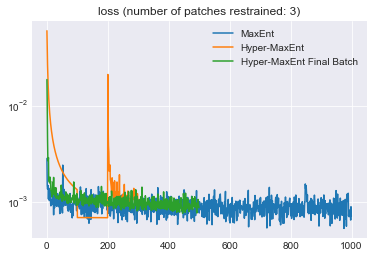

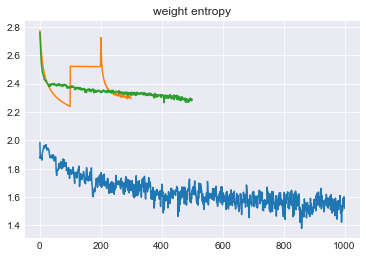

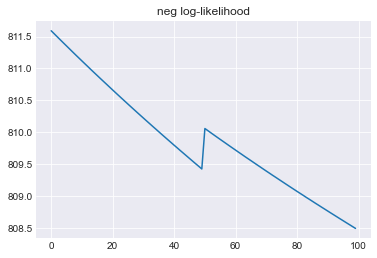

In [40]:
plt.plot(me_history.history['loss'],label='MaxEnt')
plt.plot(hme_history.history['loss'],label='Hyper-MaxEnt')
plt.plot(hme_final_history.history['loss'],label='Hyper-MaxEnt Final Batch')
plt.title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
plt.yscale('log')
plt.legend()
plt.savefig('loss_{}_restraints'.format(len(restrained_patches)),dpi= 300)
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(hme_history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

# plt.plot(hme_history.history['loss-from-ref'])
# plt.show()

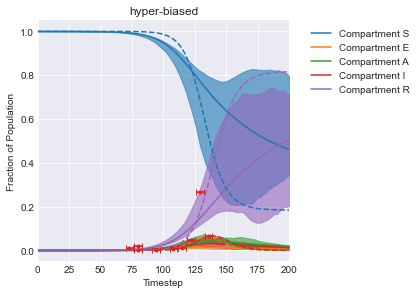

In [41]:
patch_number = 0
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(plt, hme_model.lambdas[i], color='C3')
plt.tight_layout()
# plt.ylim(0,0.2)
# plt.xlim(0,75)
plt.title('hyper-biased')
plt.show()


## Direct Regression of Model

In [42]:
T = tmat.value
start = np.zeros((M, C))
start[0,1] = 1e-6
infect = maxentep.ContactInfectionLayer(np.array([hyper_pram.beta_start,hyper_pram.beta_start]), infections_compartments, area=area)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, mobility_matrix, T, infect, Time, agreement, populations=population)

In [43]:
rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(150)
rtraj = rmodel.get_traj()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
150/150 [==============================] - 18s 123ms/step - loss: 0.3096 - output_2_loss: 0.3096


## Visualizing results

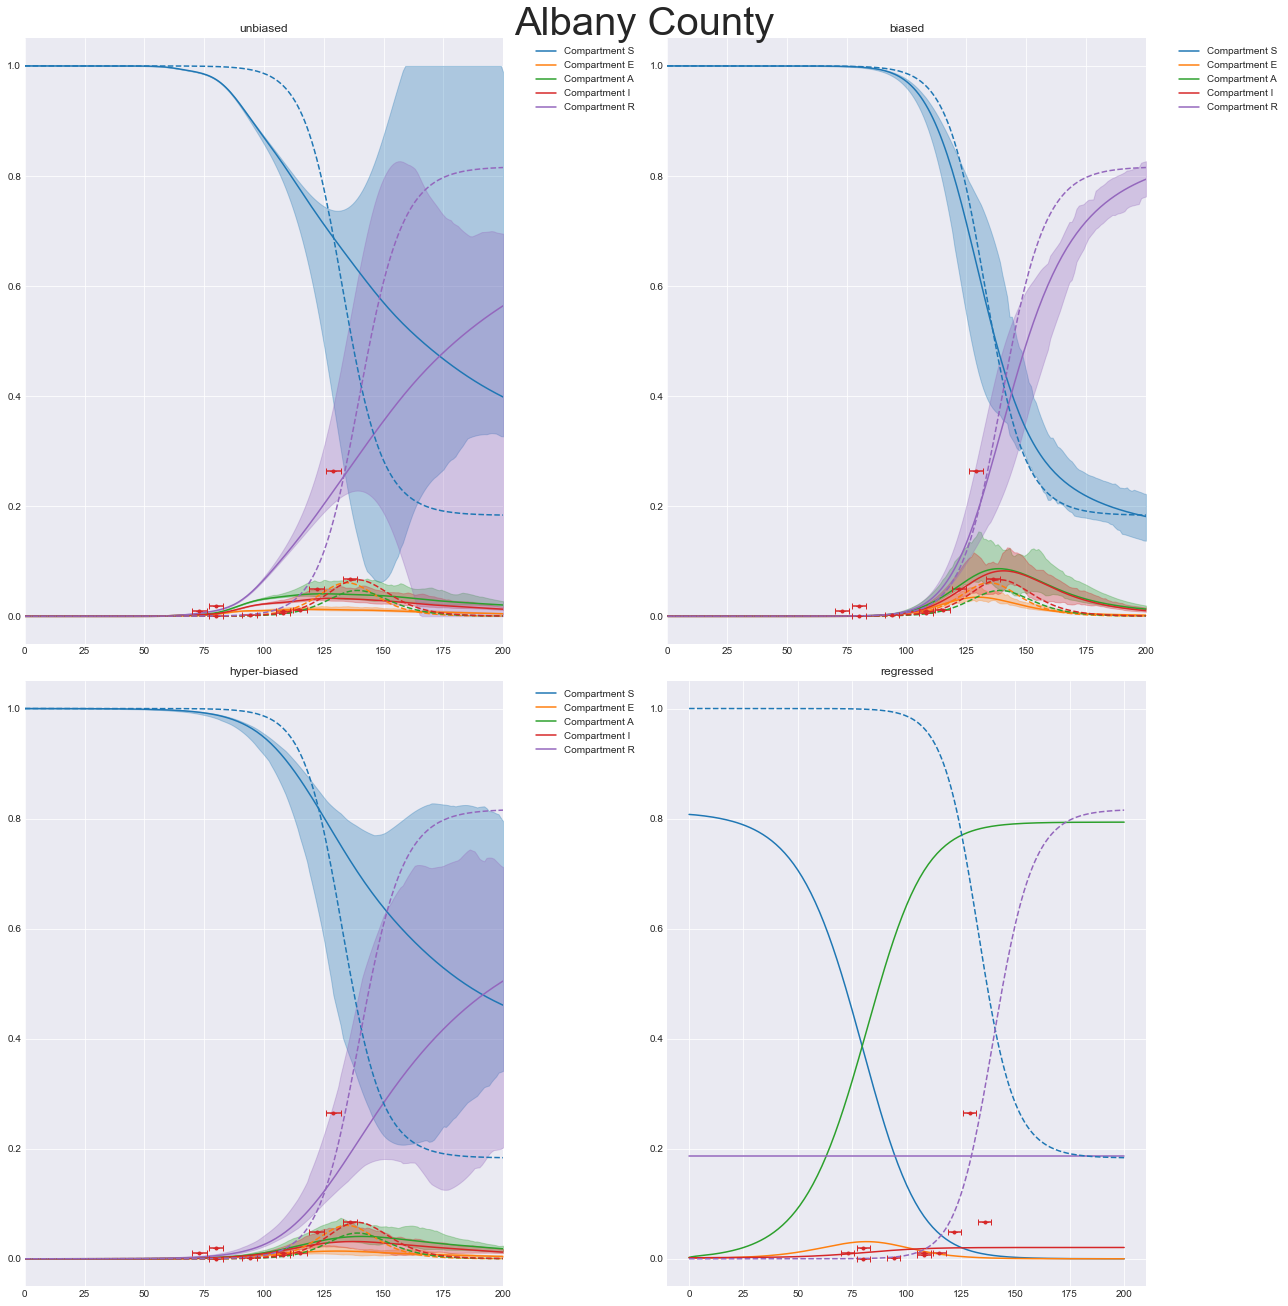

In [44]:
patch_number = 0
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0],alpha = 0.3)
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')

for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments,alpha = 0.3, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], alpha = 0.3,weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,1], 1, color='C3')

    
plt.tight_layout()
# plt.savefig('compare_Albany.png', dpi = 300)
plt.show()
plt.close()

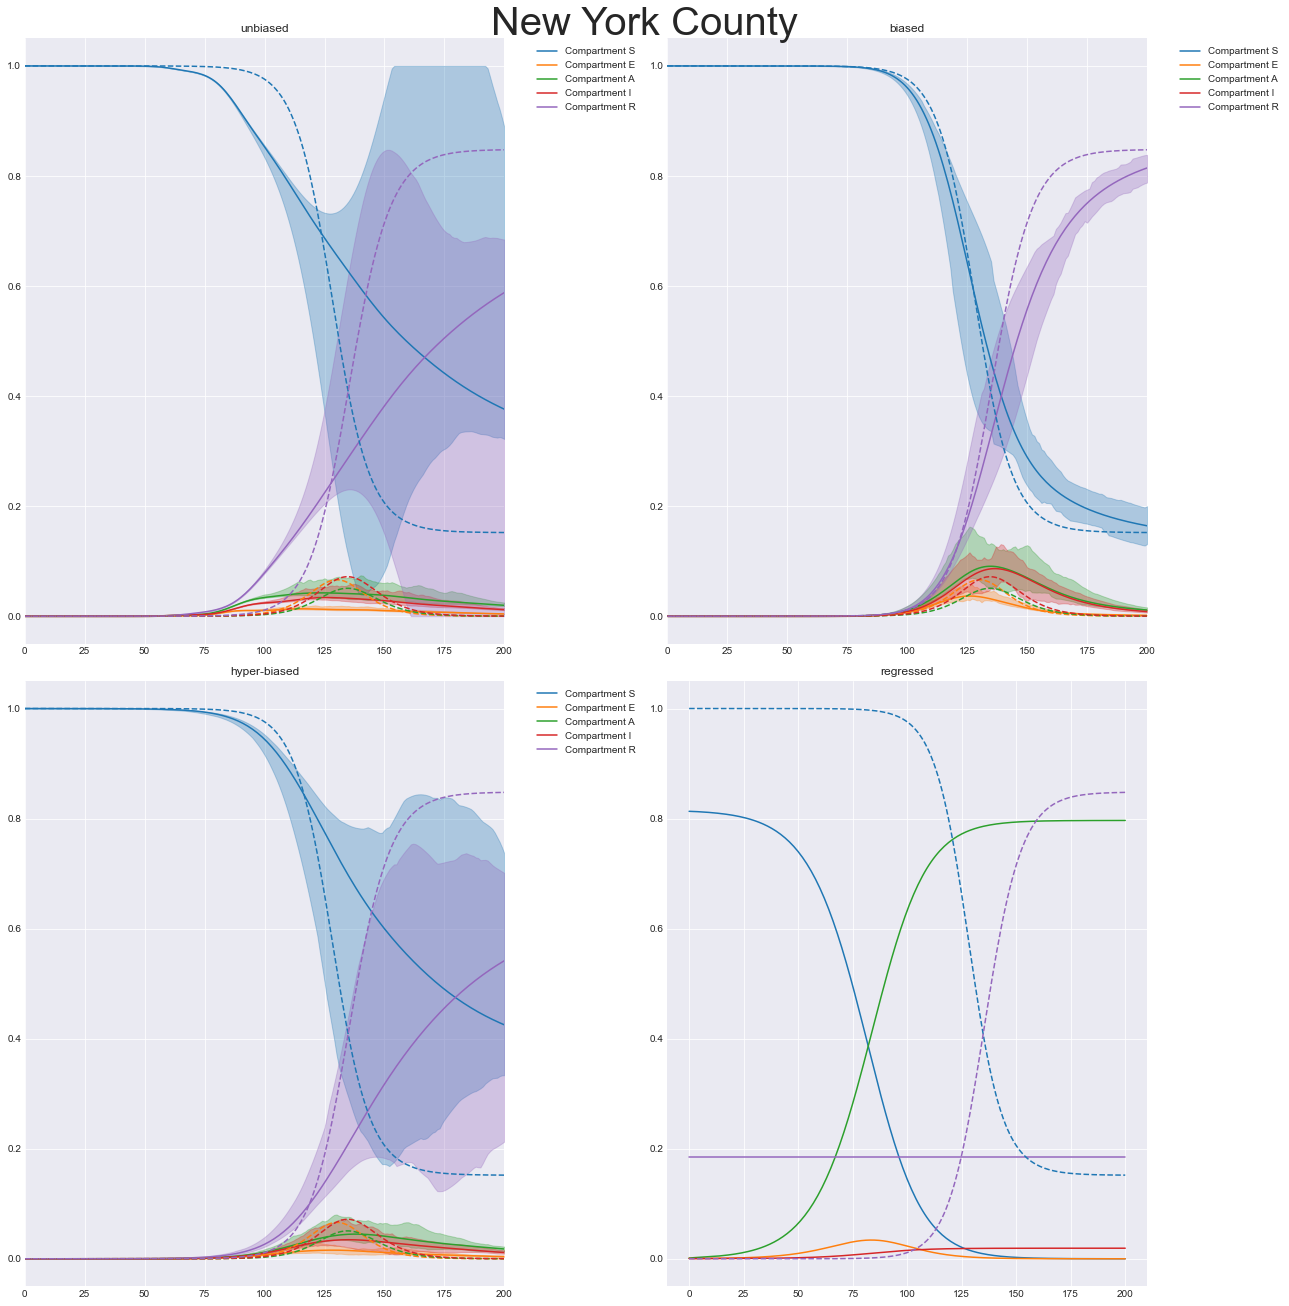

In [45]:
patch_number = 30
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0],alpha = 0.3)
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# ax[0,0].tick_params(color='green', labelcolor='green')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[0,0], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, alpha = 0.3,names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[0,1], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, alpha = 0.3,names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[1,0], hme_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
# for i,pf in enumerate(plot_fxns):
#     pf(axs[1,1], 1, color='C3')

plt.tight_layout()
# plt.savefig('compare_NY.png', dpi = 300)
plt.show()
plt.close()

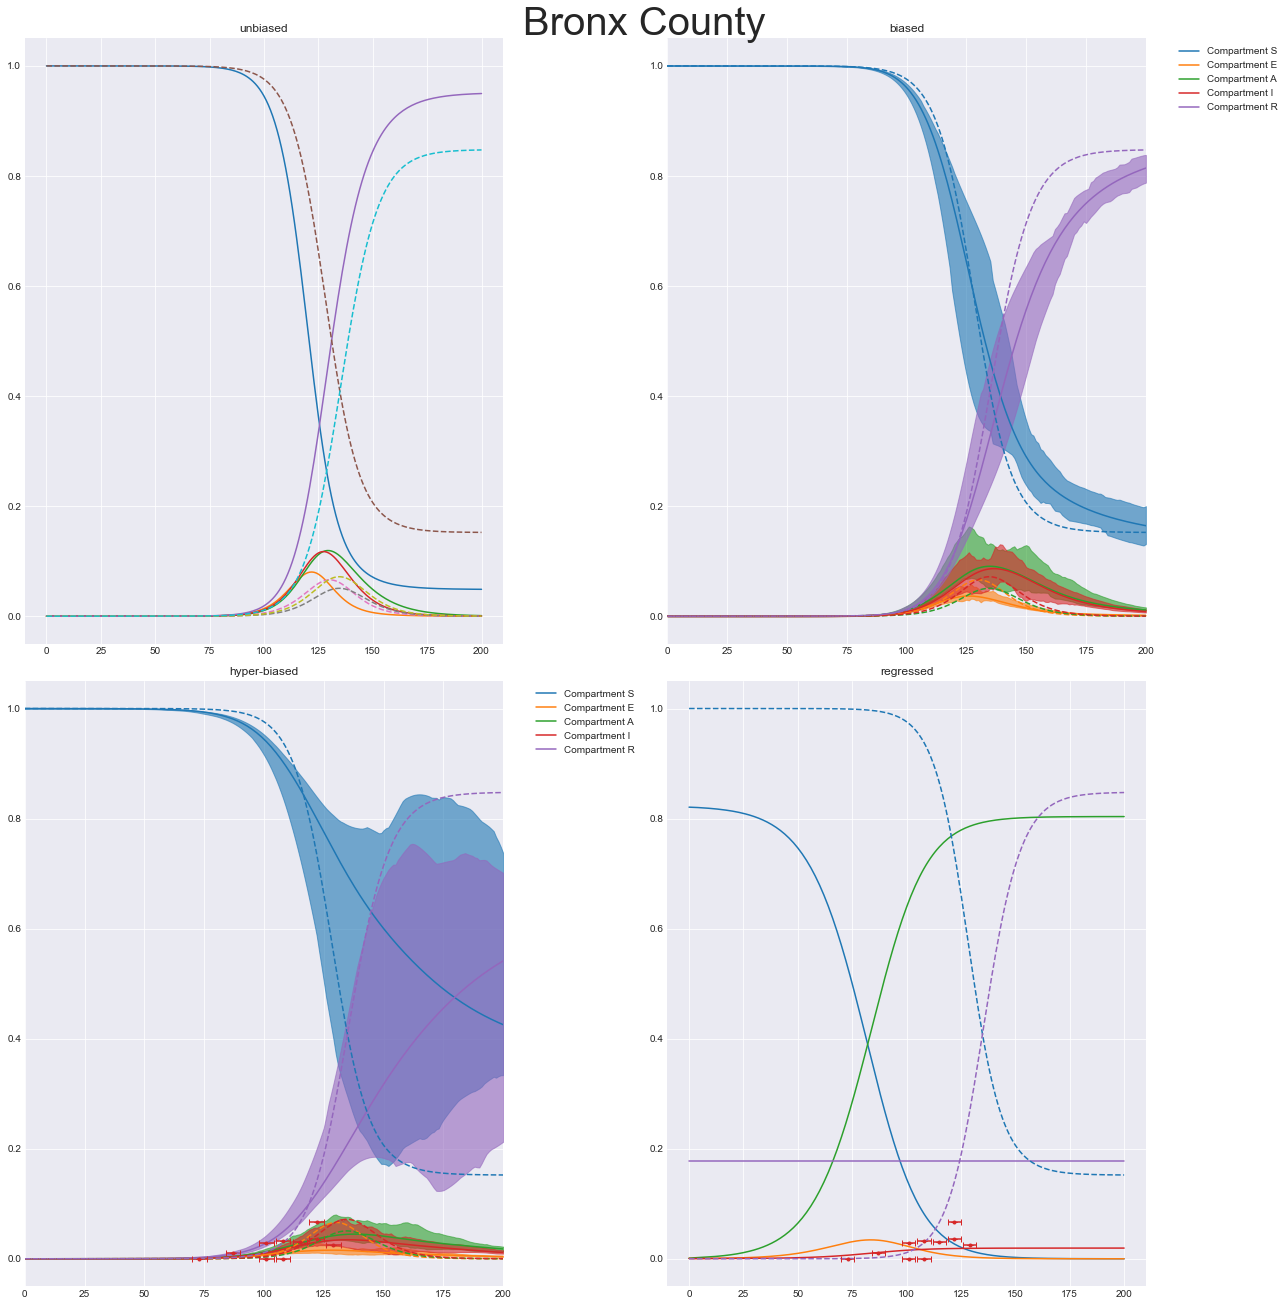

(1, 201, 62, 5)


In [46]:
patch_number = 2
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
axs[0,0].plot(trajs[0,:,patch_number,:])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns_list[patch_number]):
#     pf(axs[0,0], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
# for i,pf in enumerate(plot_fxns_list[patch_number]):
#     pf(axs[0,1], me_model.lambdas[i], color='C3')
# plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns_list[patch_number]):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
plt.savefig('compare_Livingston.png', dpi = 300)
plt.show()
print (ref_traj.shape)

In [47]:
weights_dict = {'unbiased':None, 'biased':me_model.traj_weights, 'hyper-biased':hme_model.traj_weights, 'regression':None }
from matplotlib.patches import Patch
print (restrained_patches)
def compare_patches(ref_traj,trajs,weights_dict, method ,*args, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[p,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
    plt.tight_layout()


[43  5 32]


Plotting 62 patches in a 7 x 9 grid


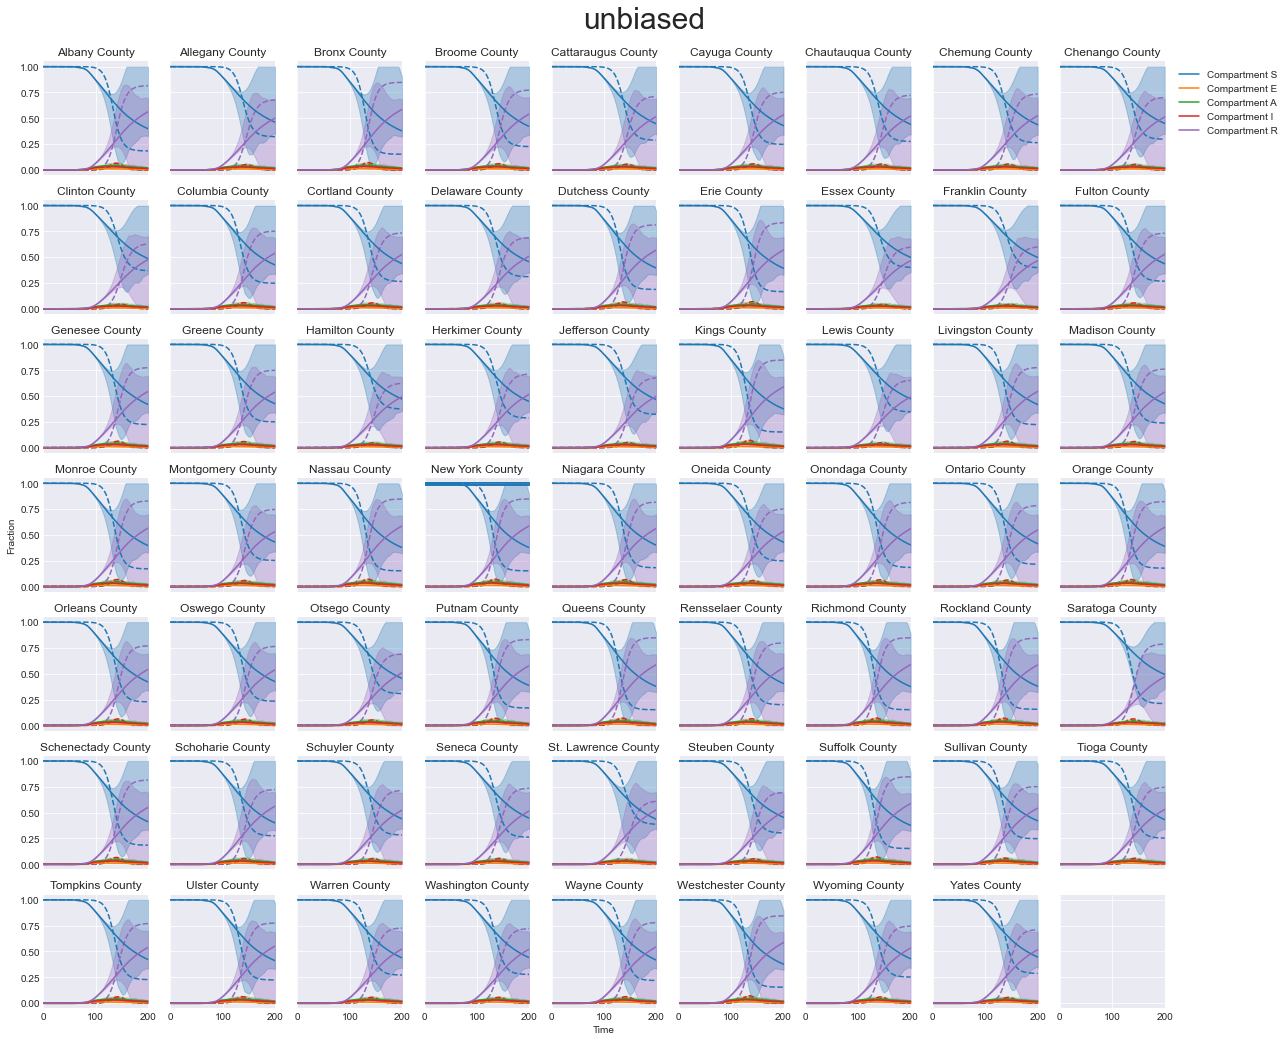

In [48]:
compare_patches(ref_traj,trajs,weights_dict,'unbiased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_unbiased.png',dpi=300)
# (ref_traj, trajs,weights_dict,'biased',patch_names = patches)

Plotting 62 patches in a 7 x 9 grid


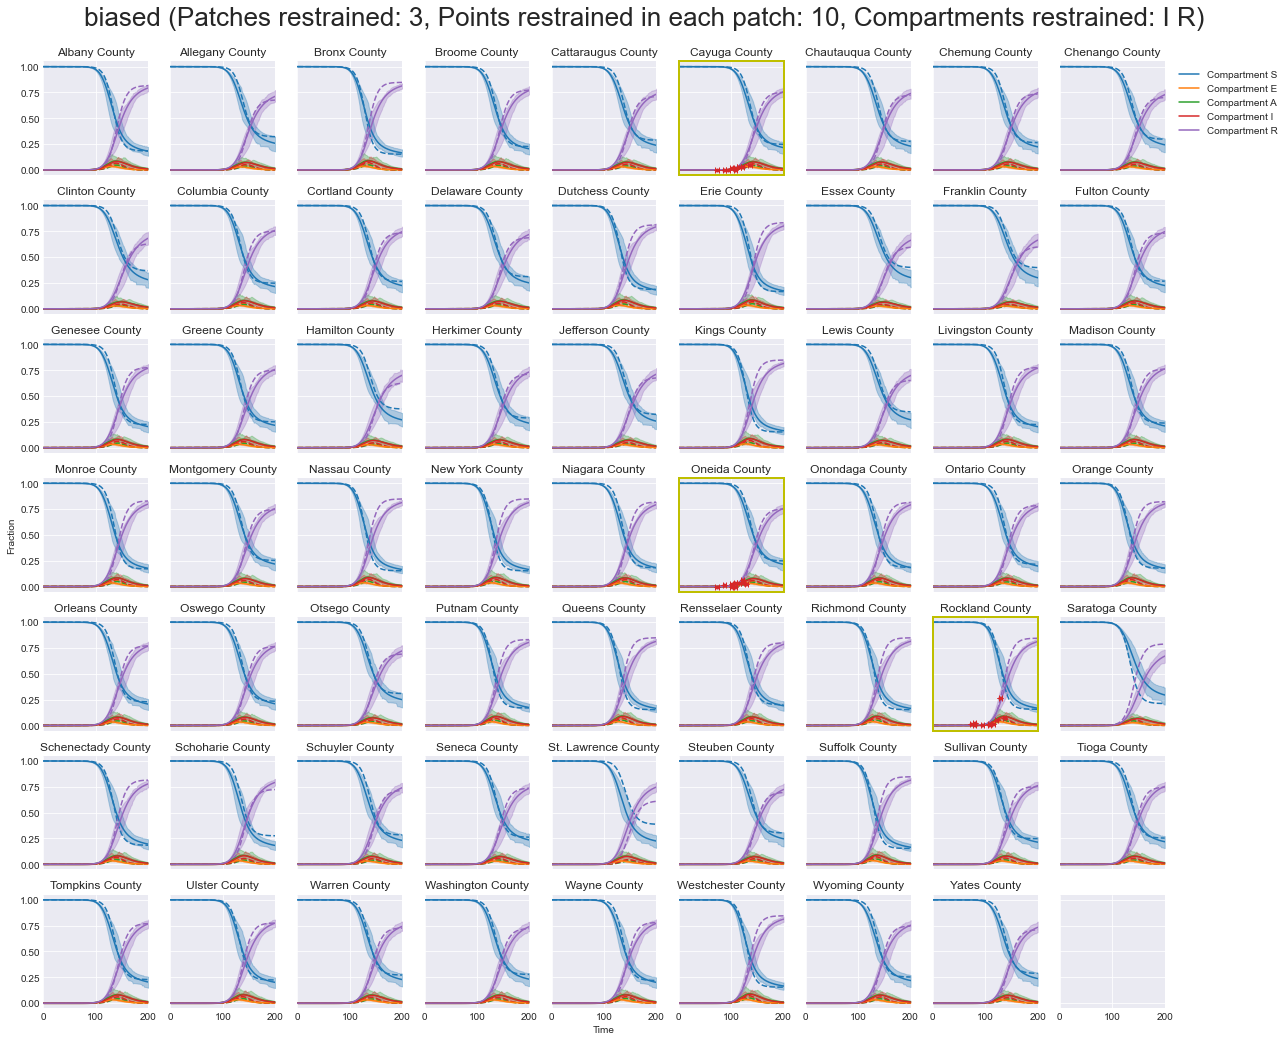

In [49]:
compare_patches(ref_traj,trajs,weights_dict,'biased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_biased_{}_restrained_{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)
# (ref_traj, trajs,weights_dict,'biased',patch_names = patches)

Plotting 62 patches in a 7 x 9 grid


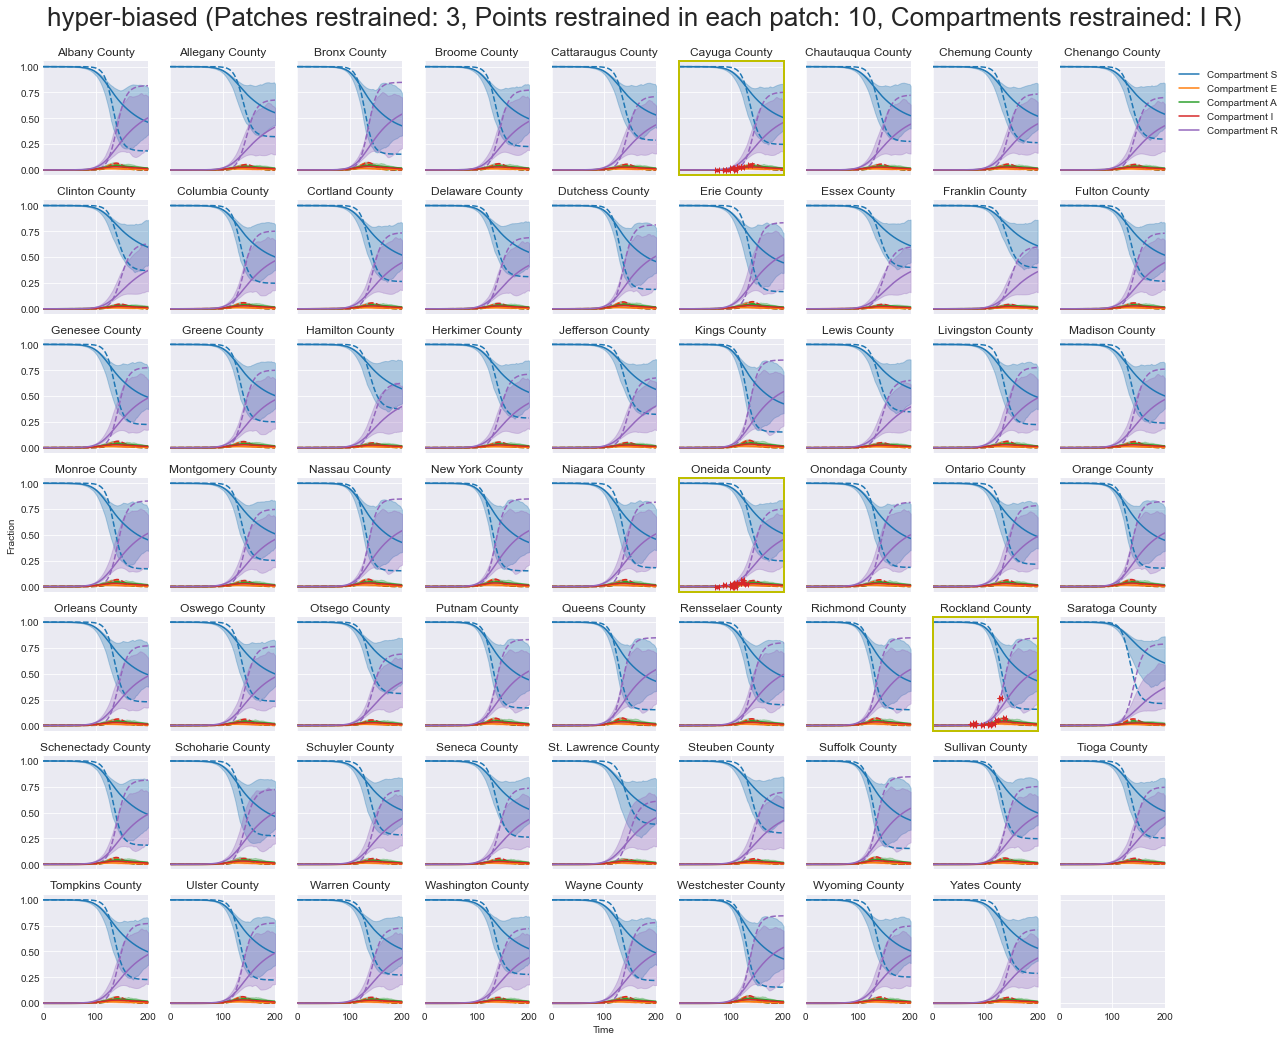

In [50]:
compare_patches(ref_traj,hme_model.trajs,weights_dict,'hyper-biased', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_hyper_{}_restrained_{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)

In [51]:
weight_hyper = weights_dict['hyper-biased']
# weight_hyper /=np.sum(weight_hyper)
# mtrajs_patch = np.sum(trajs[:,:,0,:] * weight_hyper[:, np.newaxis, np.newaxis], axis=0)
# print (trajs.shape)
# print (mtrajs_patch.shape)
# print (trajs.shape[2], trajs.shape[-1])
def mean_traj(trajs,weights=None):
    Time = trajs.shape[1]
    c = trajs.shape[-1]
    M = trajs.shape[2]
    if weights is None:
        w = np.ones(trajs.shape[0])
    else:
        w = weights
    w /= np.sum(w)
    mtrajs_counties = np.empty([Time,M,c])
    for i in range(M):
        mtrajs_counties[:,i,:] = np.sum(trajs[:,:,i,:] * w[:, np.newaxis, np.newaxis], axis=0)
    mtrajs = np.sum(mtrajs_counties*population_fraction[np.newaxis, :, np.newaxis],axis=1)
    return mtrajs

    
mtrajs_hyper_biased = mean_traj(hme_model.trajs,weights = weights_dict['hyper-biased'])



mtrajs_biased = mean_traj(trajs,weights = weights_dict['biased'])
mtrajs_unbiased = mean_traj(trajs)
# REF = ref_traj[p,:,:,:]
# REF = np.expand_dims(REF,axis=0)
mref_traj = mean_traj(ref_traj)


mref_traj = mref_traj[:,:5]

loss_unbiased = np.mean((mref_traj- mtrajs_unbiased)**2)
loss_biased = np.mean((mref_traj- mtrajs_biased)**2)
loss_hyper_biased = np.mean((mref_traj- mtrajs_hyper_biased)**2)



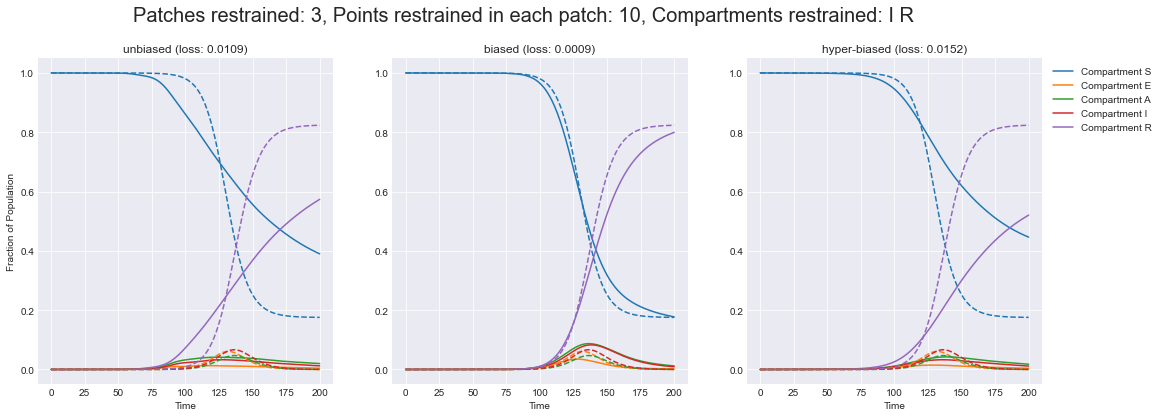

0.9999999781859057


In [52]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
fig.suptitle('Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {}'
             .format(len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names), fontsize=20,y=1.00)

axs[0].set_title('unbiased (loss: {})'.format(np.round(loss_unbiased,4)))
axs[1].set_title('biased (loss: {})'.format(np.round(loss_biased,4)))
axs[2].set_title('hyper-biased (loss: {})'.format(np.round(loss_hyper_biased,4)))
for i in range(mref_traj.shape[-1]):
    axs[0].plot(range(Time),mtrajs_unbiased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')
    axs[1].plot(range(Time),mtrajs_biased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')
    axs[2].plot(range(Time),mtrajs_hyper_biased[:,i],color=f'C{i}',label=f'Compartment {full_compartments[i]}')

axs[0].plot(mref_traj,linestyle='--')
axs[1].plot(mref_traj,linestyle='--')
axs[2].plot(mref_traj,linestyle='--')
axs[2].legend(bbox_to_anchor=(1.4, 1))
plt.setp(axs[:], xlabel='Time')
plt.setp(axs[0], ylabel='Fraction of Population')

# plt.tight_layout()
plt.savefig('compare_means_restraints_{}{}.png'.format(len(restrained_patches),restrained_compartments_names),dpi=300)
plt.show()
print (np.sum(mtrajs_biased[-1]))

In [53]:
Loss = np.mean((mref_traj- mtrajs_unbiased)**2)
print (Loss)

# print(end - start)

0.010949858411096757


Plotting 62 patches in a 7 x 9 grid


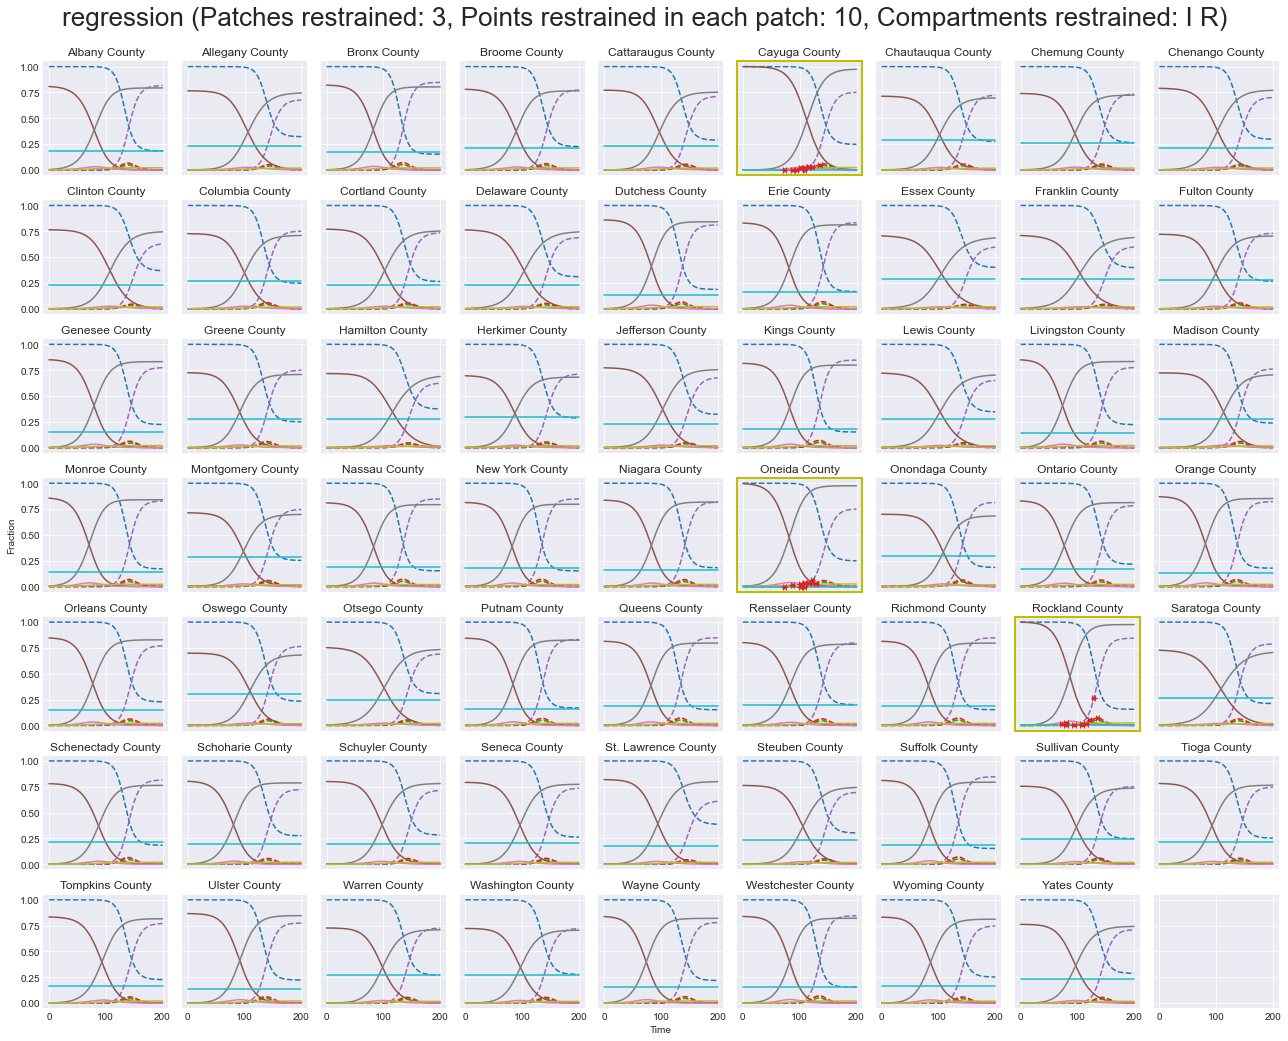

In [54]:
compare_patches(ref_traj,trajs,weights_dict,'regression', patch_names = patches, figsize=(18, 14), alpha=0.3, names=full_compartments)
plt.tight_layout()
plt.savefig('compare_regression.png',dpi=300)


# Parameter posterior distributions

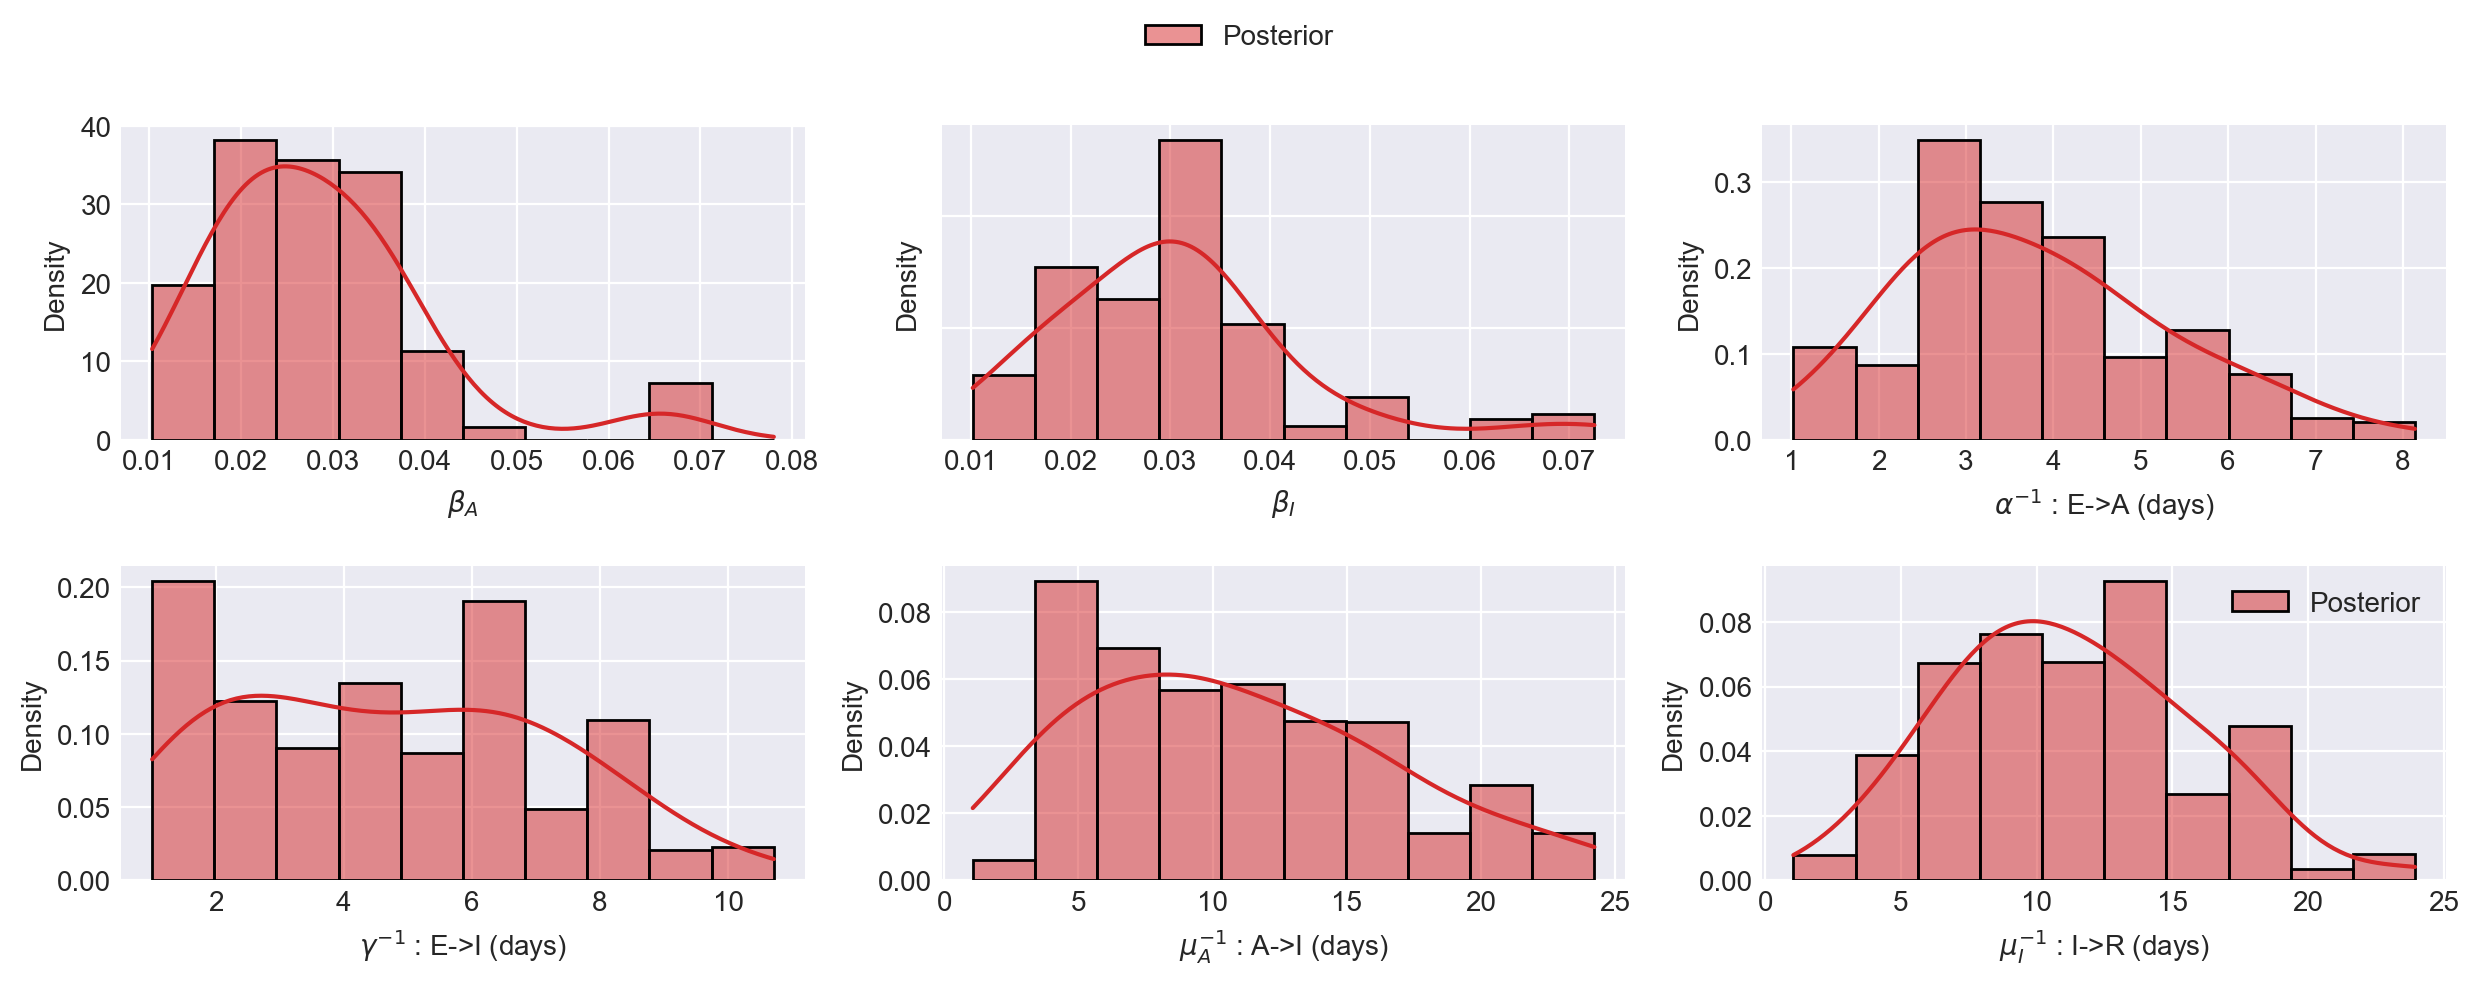

In [55]:
E_A, E_I, A_R, I_R, start_exposed_dist, beta_dist = prior_param_dist
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=200)
sns.histplot(x=np.squeeze(beta_dist[...,0]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,0], kde=True, stat="density")
axs[0,0].set_xlabel(r'$\beta_{A}$')

sns.histplot(x=np.squeeze(beta_dist[...,1]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,1], kde=True, stat="density")
axs[0,1].set_xlabel(r'$\beta_{I}$')

sns.histplot(x=np.squeeze(E_A), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,2], kde=True, stat="density")
axs[0,2].set_xlabel(r'$\alpha^{-1}$ : E->A (days)')

sns.histplot(x=np.squeeze(E_I), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,0], kde=True, stat="density")
axs[1,0].set_xlabel(r'$\gamma ^{-1}$ : E->I (days)')

sns.histplot(x=np.squeeze(A_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,1], kde=True, stat="density")
axs[1,1].set_xlabel(r'$\mu_{A} ^{-1}$ : A->I (days)')

sns.histplot(x=np.squeeze(I_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,2], kde=True, stat="density")
axs[1,2].set_xlabel(r'$\mu_{I}^{-1}$ : I->R (days)')


handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.4)
# axs[-1, -1].axis('off')
axs[0,1].set_yticklabels('')
plt.legend()
# sns.displot(x=np.squeeze(beta_dist),stat="density", kde=True)

# Compare posterior with prior

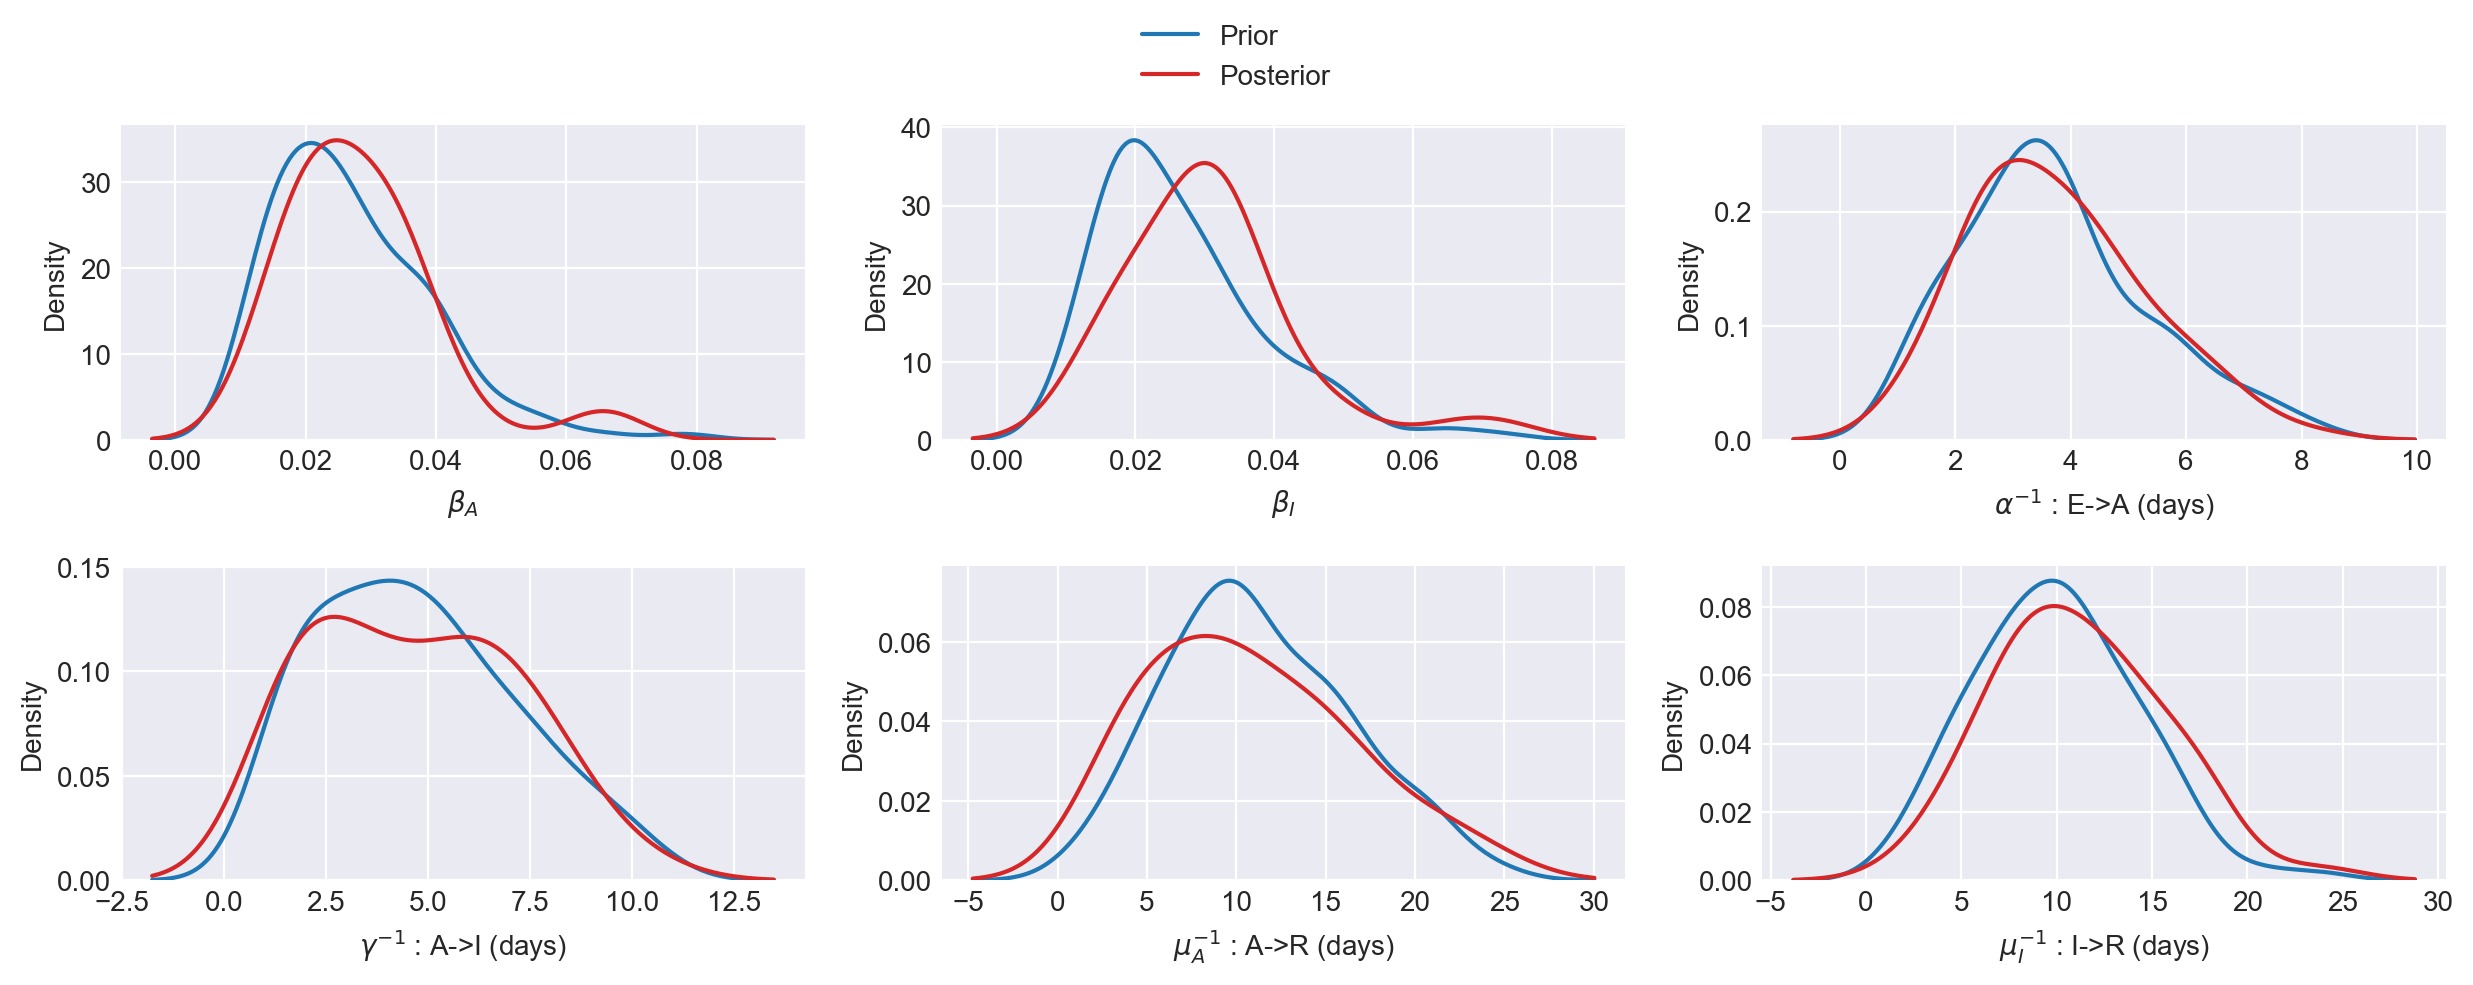

In [74]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,5), dpi=200)
sns.kdeplot(x=np.squeeze(beta_dist[...,0]), label='Prior',
            color='C0', ax=axs[0,0])
sns.kdeplot(x=np.squeeze(beta_dist[...,0]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,0])
# sns.histplot(x=np.squeeze(beta_dist), weights=hme_model.traj_weights, label='Posterior',
#             color='C3', ax=axs[0,0], stat="density",kde=True)
axs[0,0].set_xlabel(r'$\beta_{A}$')
sns.kdeplot(x=np.squeeze(beta_dist[...,1]), label='Prior',
            color='C0', ax=axs[0,1])
sns.kdeplot(x=np.squeeze(beta_dist[...,1]), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,1])
axs[0,1].set_xlabel(r'$\beta_{I}$')

# sns.displot(x=np.squeeze(beta_dist),stat="density", kde=True)
sns.kdeplot(x=np.squeeze(E_A), label='Prior',
            color='C0', ax=axs[0,2])
sns.kdeplot(x=np.squeeze(E_A), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[0,2])
axs[0,2].set_xlabel(r'$\alpha^{-1}$ : E->A (days)')

sns.kdeplot(x=np.squeeze(E_I), label='Prior',
            color='C0', ax=axs[1,0])
sns.kdeplot(x=np.squeeze(E_I), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,0])
axs[1,0].set_xlabel(r'$\gamma ^{-1}$ : A->I (days)')

sns.kdeplot(x=np.squeeze(A_R), label='Prior',
            color='C0', ax=axs[1,1])
sns.kdeplot(x=np.squeeze(A_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,1])
axs[1,1].set_xlabel(r'$\mu_{A}^{-1}$ : A->R (days)')

sns.kdeplot(x=np.squeeze(I_R), label='Prior',
            color='C0', ax=axs[1,2])
sns.kdeplot(x=np.squeeze(I_R), weights=me_model.traj_weights, label='Posterior',
            color='C3', ax=axs[1,2],legend=False)
axs[1,2].set_xlabel(r'$\mu_{I}^{-1}$ : I->R (days)')

handles, labels = axs[0,0].get_legend_handles_labels()
# axs[1,2].get_legend().set_visible(False)
fig.legend(handles, labels, loc='upper center')
plt.subplots_adjust(hspace=0.4)
# axs[-1, -1].axis('off')
# plt.legend()
plt.savefig('compare_param_dist.png', dpi=300)

In [57]:
me_w = me_model.traj_weights
prior_exposed_patch = maxentep.exposed_finder(trajs)
posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)


In [58]:
# maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=10, figsize=(10,8))
# maxentep.p0_map(prior_exposed_patch, M, weights = me_w, patch_names=patches, title = 'Posterior patient-zero probability', fontsize=10,figsize=(10,8))

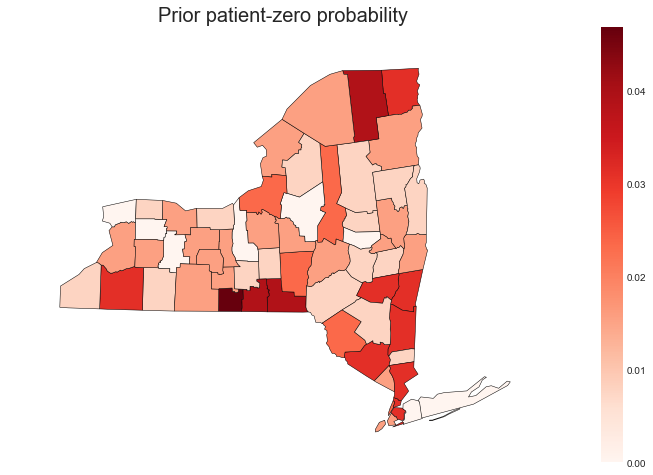

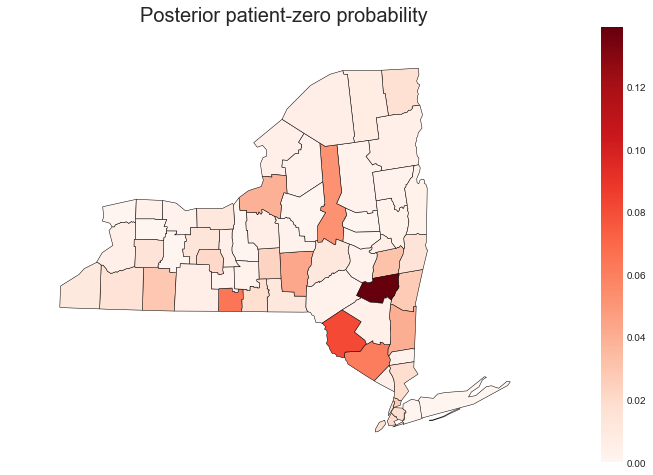

In [59]:
maxentep.p0_map(prior_exposed_patch, M, weights = None, patch_names=patches, title = 'Prior patient-zero probability', fontsize=20, choropleth=True,
       geojson='counties_ny.geojson')
maxentep.p0_map(prior_exposed_patch, M, weights = me_w, title = 'Posterior patient-zero probability', patch_names=patches, fontsize=20
      , choropleth=True, geojson='counties_ny.geojson')

Finding the top 5 most probable locations for the origin of outbreak:

In [60]:
sorted(zip(posterior_exposed_prob, patches), reverse=True)[:5]

[(0.1390345797236805, 'Greene County'),
 (0.08178434259730401, 'Sullivan County'),
 (0.06446321102709238, 'Chemung County'),
 (0.06104841633349949, 'Orange County'),
 (0.05257145892546929, 'Herkimer County')]

## Theory 1
Basic reproductive number ($R_0$):

$ S \xrightarrow{\beta} E \xrightarrow{\eta} A \xrightarrow{\alpha} I \xrightarrow{\mu} R $

$R_0 = \frac{\beta S_0}{\alpha} +  \frac{\beta S_0}{\mu } $

$ t_{max} \sim \frac{log(S_0)}{\mu (R_0 -1)}$

In [61]:
# total_pop = np.sum(population)
# R0 = beta*total_pop*(1/alpha + 1/mu)

In [62]:
# t_max = np.log(total_pop)/mu/(R0-1)

In [63]:
# t_max